Imports

In [1]:
import cifar
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from dataclasses import dataclass, field

In [2]:
@dataclass
class ImageMetaData():
    rgb: np.ndarray
    grayscale: np.ndarray = field(init = False)
    filename: str
    img_class: str
    
    def __post_init__(self):
        self.grayscale = cv.cvtColor(self.rgb, cv.COLOR_RGB2GRAY)

In [3]:
# Pure red/green/blue values
RED_U8 = (255, 0, 0)
GREEN_U8 = (0, 255, 0)
BLUE_U8 = (0, 0, 255)

FIGURE_PATH = "figures/hw2"

os.makedirs(FIGURE_PATH, exist_ok = True)

def figure_path(name: str):
    return os.path.join(FIGURE_PATH, name)

In [4]:
np.random.seed(200)

In [5]:
data = cifar.unpack("data_batch_2")

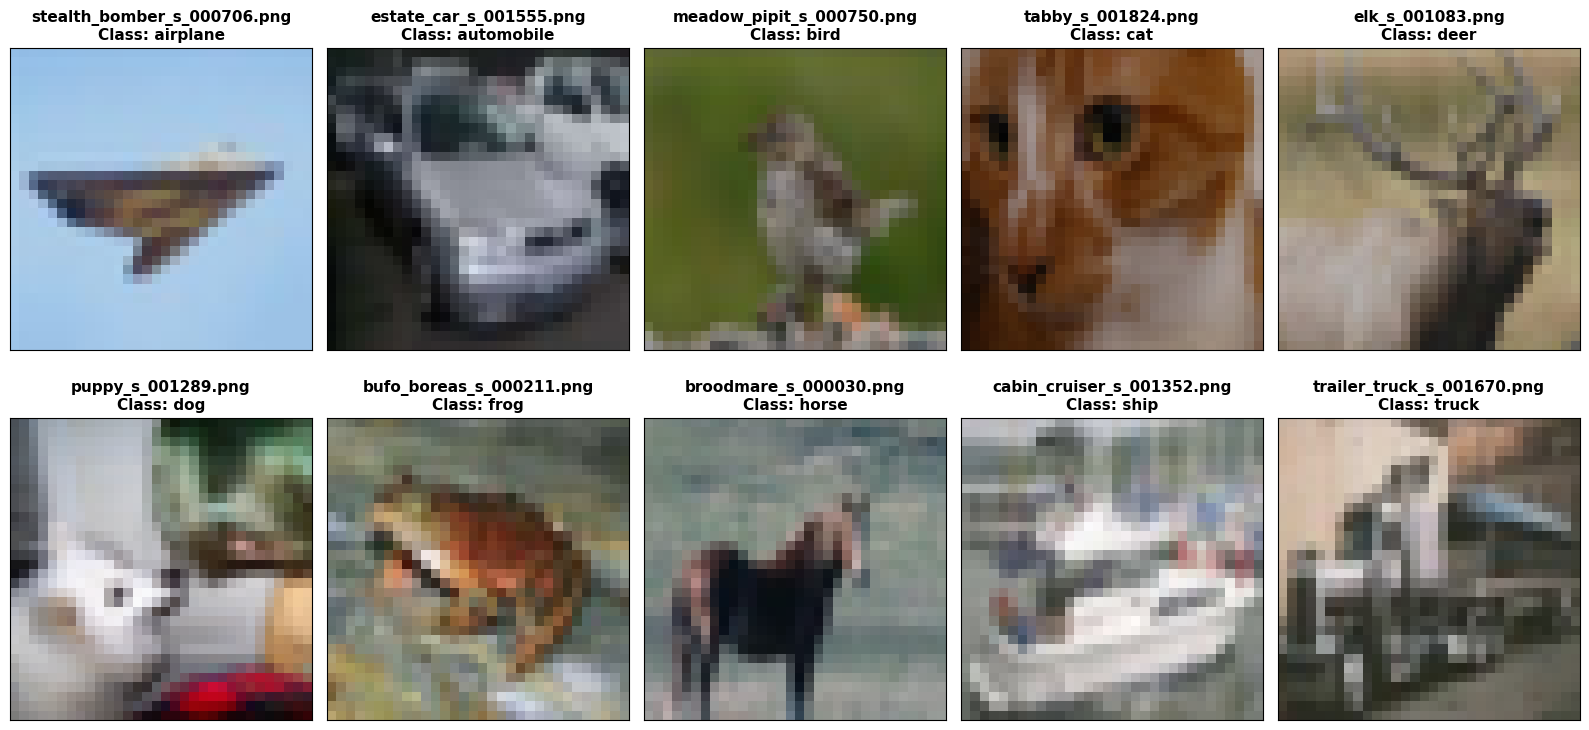

In [6]:
fig, ax = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax = ax.flatten() # flatten array to iterate with a single loop

# initialize list of image containers
img_data: list[ImageMetaData] = []

for ii in range(10):
    # get images corresponding to a given label
    imgs, names = cifar.get_images_by_label(data, label = ii)
    
    # randomly select an index in the list of images to use as image for a given class
    rand_img_index = np.random.randint(0, len(imgs)-1)
    
    # append image metadata to list to store for remaining HW assignment parts
    img_data.append(
        ImageMetaData(
            rgb = cifar.data_to_rgb_image(imgs[rand_img_index]),
            filename = names[rand_img_index],
            img_class = cifar.label_index_to_name(ii)
        )
    )
    
    # visualize image
    ax[ii].imshow(img_data[ii].rgb)
    ax[ii].set_title(f"{img_data[ii].filename}\nClass: {img_data[ii].img_class}", fontsize = 11, fontweight = 'bold')
    
    # remove x/y-ticks from image
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
    ax[ii].set_xticklabels([])
    ax[ii].set_yticklabels([])
    
# save figure
fig.savefig(figure_path("raw_images.png"))

Hough Lines

In [7]:
1/32

0.03125

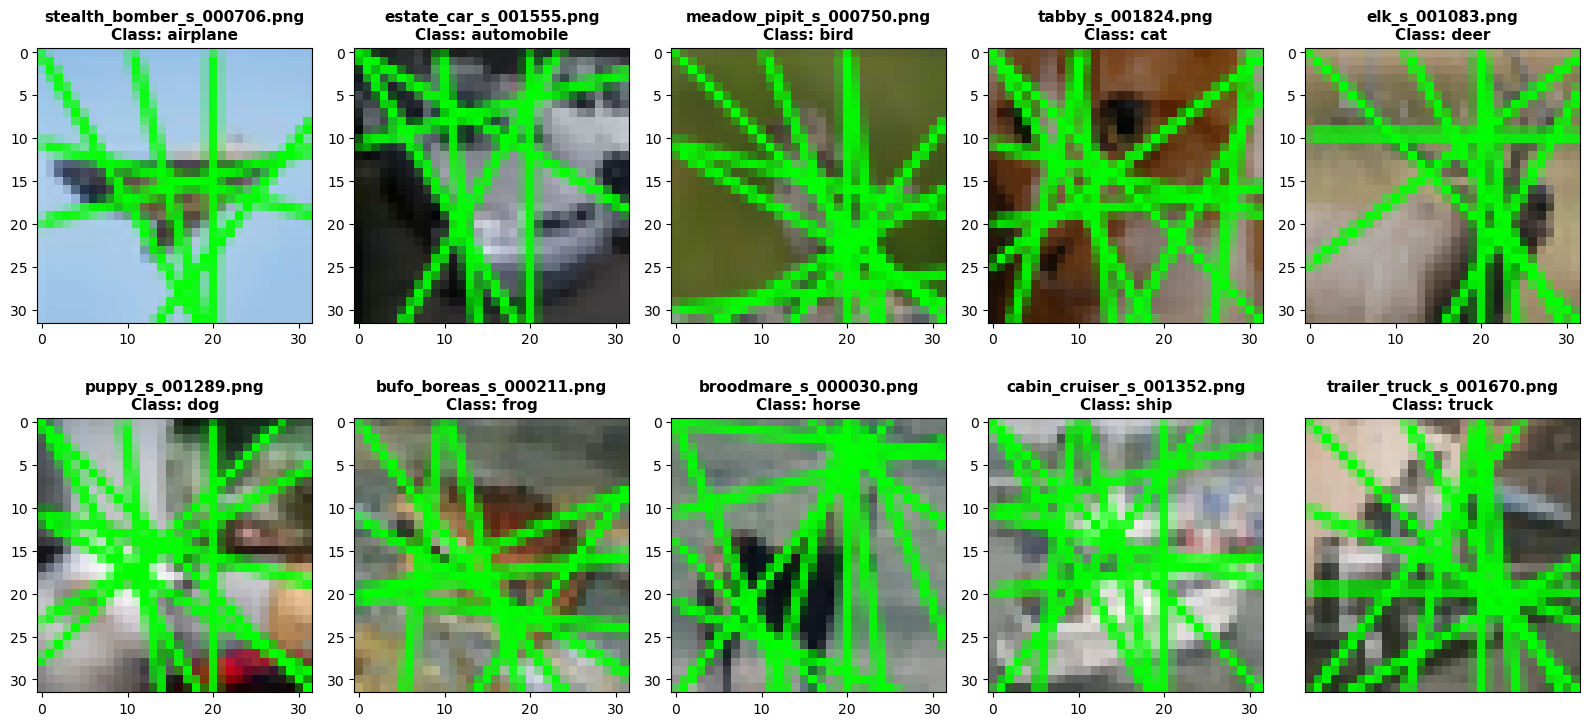

In [8]:
fig, ax = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax = ax.flatten() # flatten array to iterate with a single loop

# Parameters
rho_ = 10
theta_ = np.radians(7.5)
threshold_ = 30

for a, img in zip(ax, img_data):   
    src_line = np.copy(img.rgb)
         
    # HoughLines() 
    # docs: https://docs.opencv.org/4.9.0/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a
    # OpenCV example: https://docs.opencv.org/4.9.0/d9/db0/tutorial_hough_lines.html
    hough_lines = cv.HoughLines(
        image = cv.Canny(img.grayscale, 50, 250),
        rho = rho_,
        theta = theta_,
        threshold = threshold_,
    )

    if hough_lines is not None:
        for line in hough_lines:
            rho, theta = line[0]
            m = np.cos(theta)
            b = np.sin(theta)
            x0 = m * rho
            y0 = b * rho
            
            pt1 = (
                int(x0 + 64*(-b)), 
                int(y0 + 64*(m))
            )
            
            pt2 = (
                int(x0 - 64*(-b)), 
                int(y0 - 64*(m))
            )

            src_line = cv.line(src_line, pt1, pt2, GREEN_U8, 1, cv.LINE_AA)
    
    # Visualize image
    a.imshow(src_line)    
    a.set_title(f"{img.filename}\nClass: {img.img_class}", fontsize = 11, fontweight = 'bold')
    
    # remove x/y-ticks from image
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
    ax[ii].set_xticklabels([])
    ax[ii].set_yticklabels([])
    
fig.savefig(figure_path(f"hough_lines_rho_{rho_}_theta_{np.degrees(theta_):.1f}_threshold_{threshold_}.png"))

Hough Circles

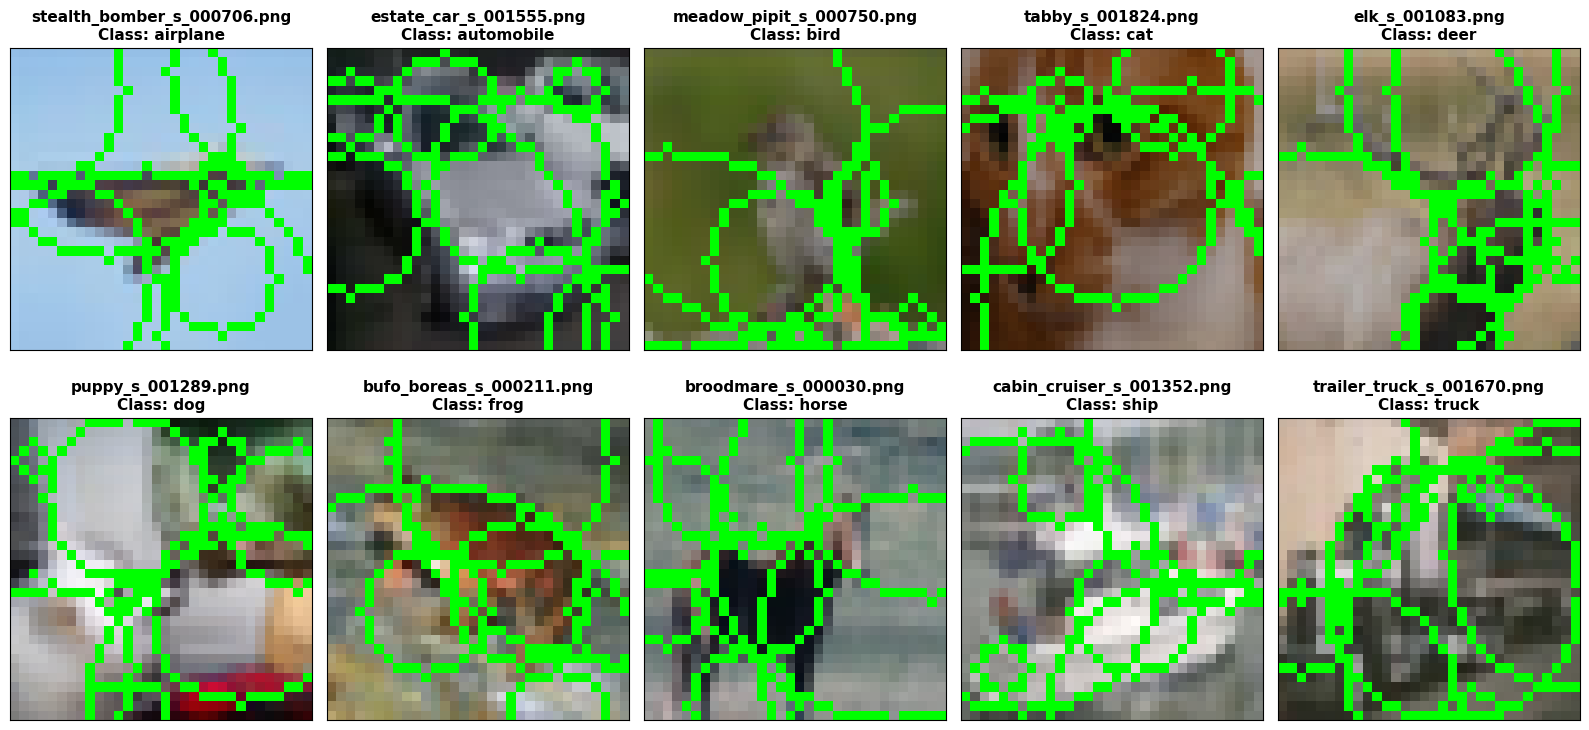

In [9]:
fig, ax = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax = ax.flatten() # flatten array to iterate with a single loop

# Parameters
dp_ = 1.0
minDist_ = 10
param1_ = 300
param2_ = 0.8

for a, img in zip(ax, img_data):   
    src_circle = np.copy(img.rgb)
                 
    # HoughCircles() 
    # docs: https://docs.opencv.org/4.9.0/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
    # OpenCV example: https://docs.opencv.org/4.9.0/da/d53/tutorial_py_houghcircles.html
    hough_circles = cv.HoughCircles(
        image = cv.medianBlur(img.grayscale, 3),
        method = cv.HOUGH_GRADIENT,
        dp = dp_,
        minDist = minDist_,
        param1 = param1_,
        param2 = param2_
    )
        
    if hough_circles is not None:
        # Round values and convert to U8
        hough_circles = np.uint8(np.around(hough_circles))
        for cx, cy, cr in hough_circles[0,:]:
            # Draw the circle
            cv.circle(src_circle, (cx, cy), cr, GREEN_U8, 1)
            
    # visualize image
    a.imshow(src_circle)
    a.set_title(f"{img.filename}\nClass: {img.img_class}", fontsize = 11, fontweight = 'bold')
    
    # remove x/y-ticks from image
    a.set_xticks([])
    a.set_yticks([])
    a.set_xticklabels([])
    a.set_yticklabels([])
    
fig.savefig(figure_path(f"hough_circles_dp_{dp_}_minDist_{minDist_}_params_{param1_}_{param2_}.png"))

SIFT 

C:\Users\thegr\AppData\Local\Temp\ipykernel_27296\2819138234.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)


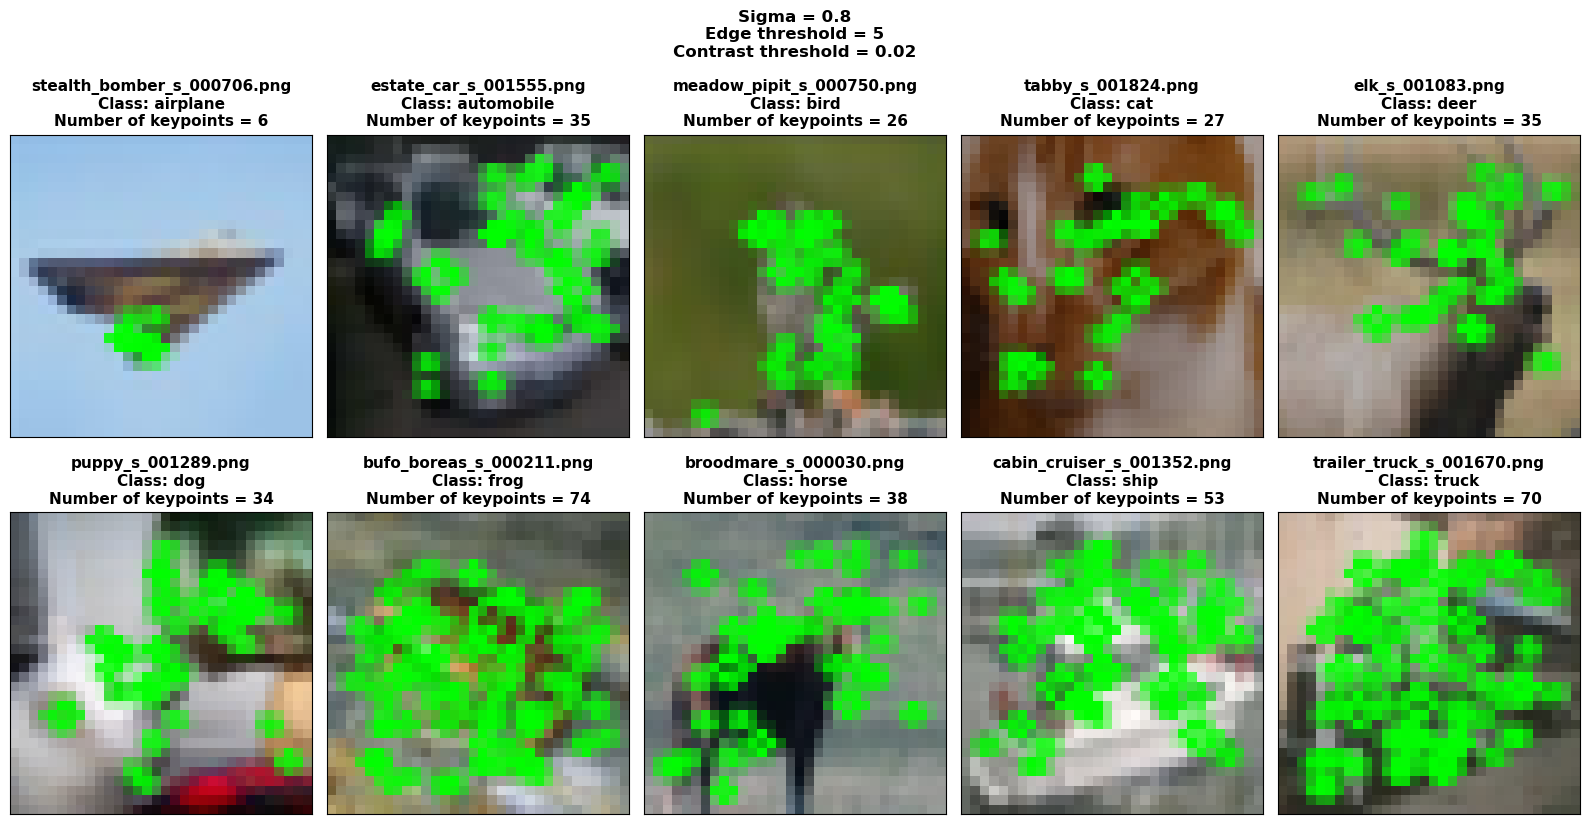

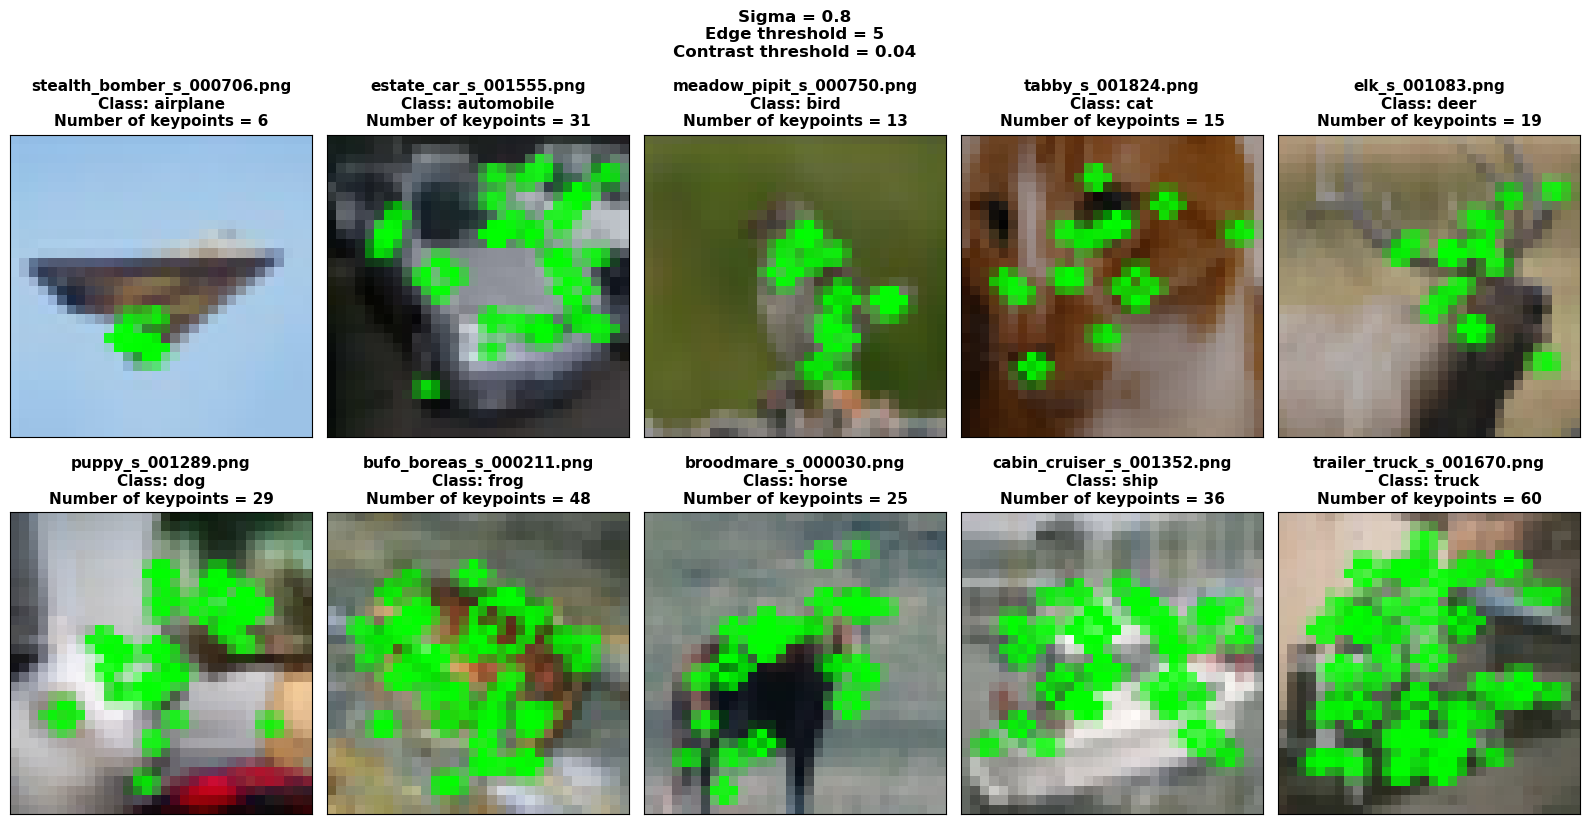

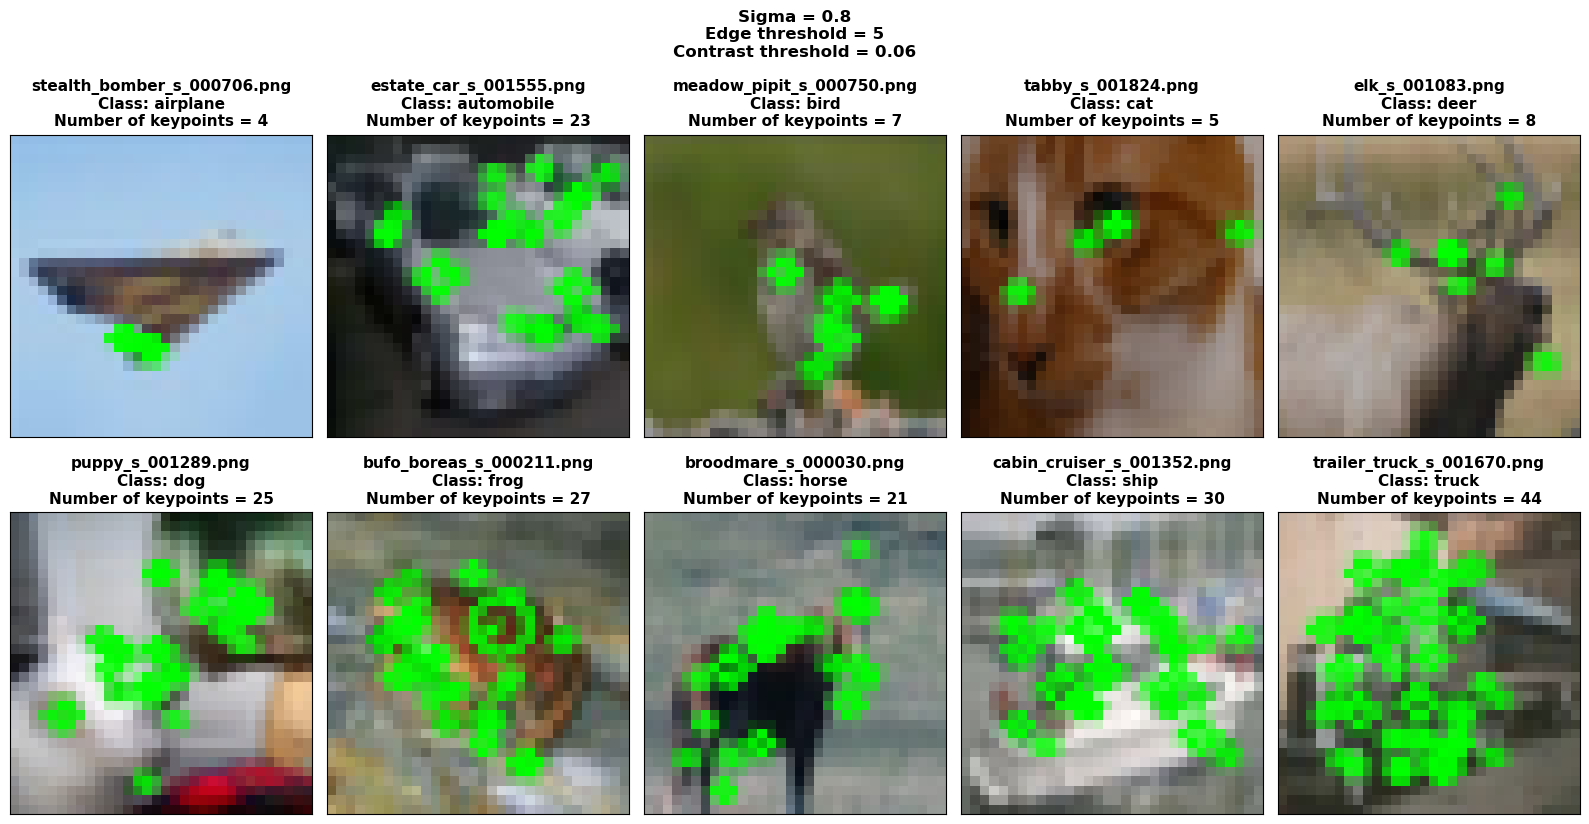

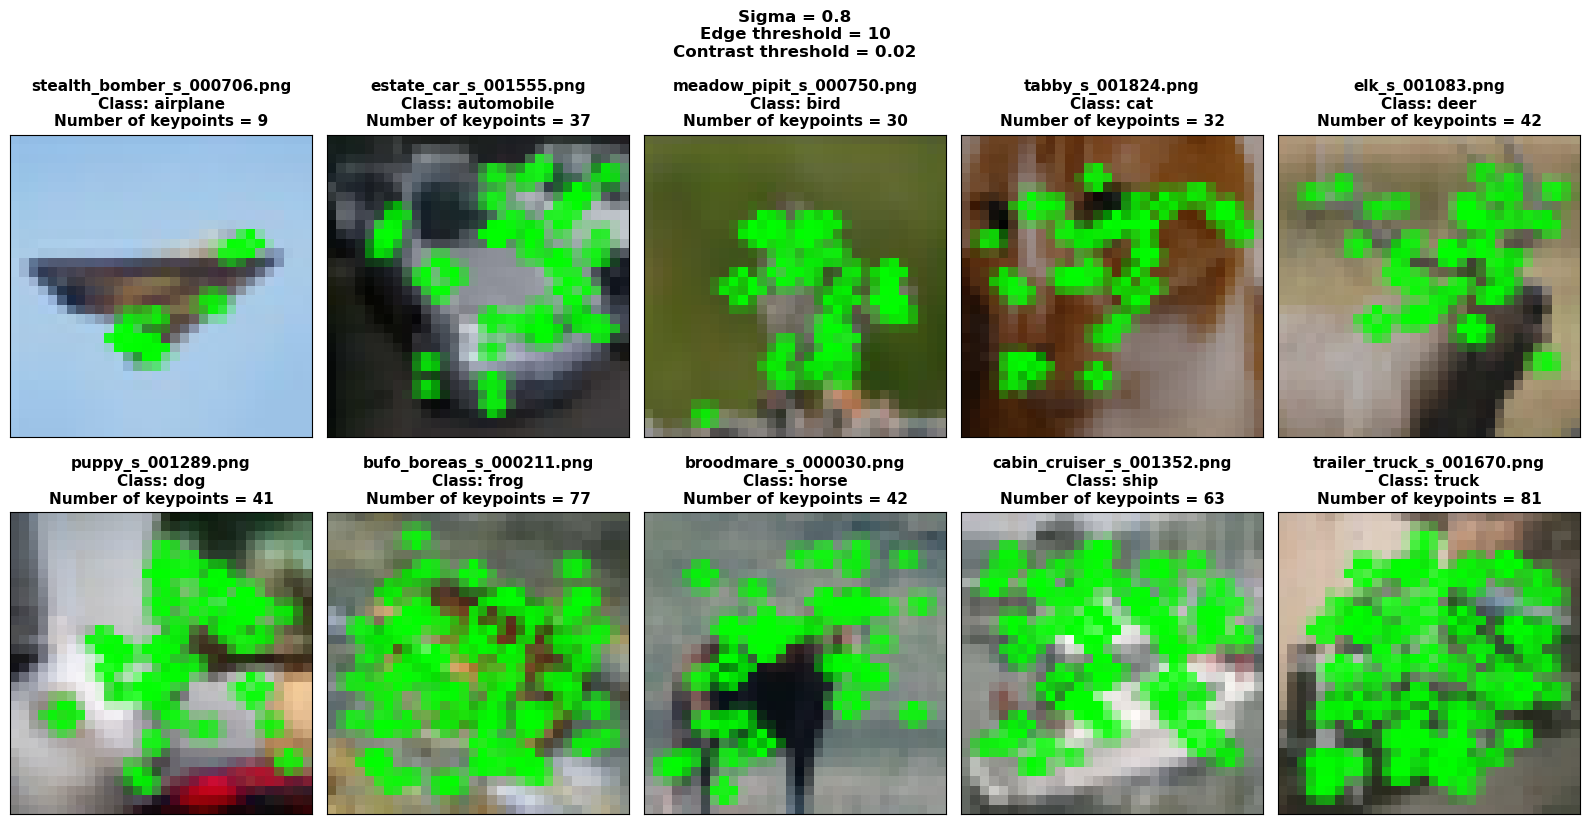

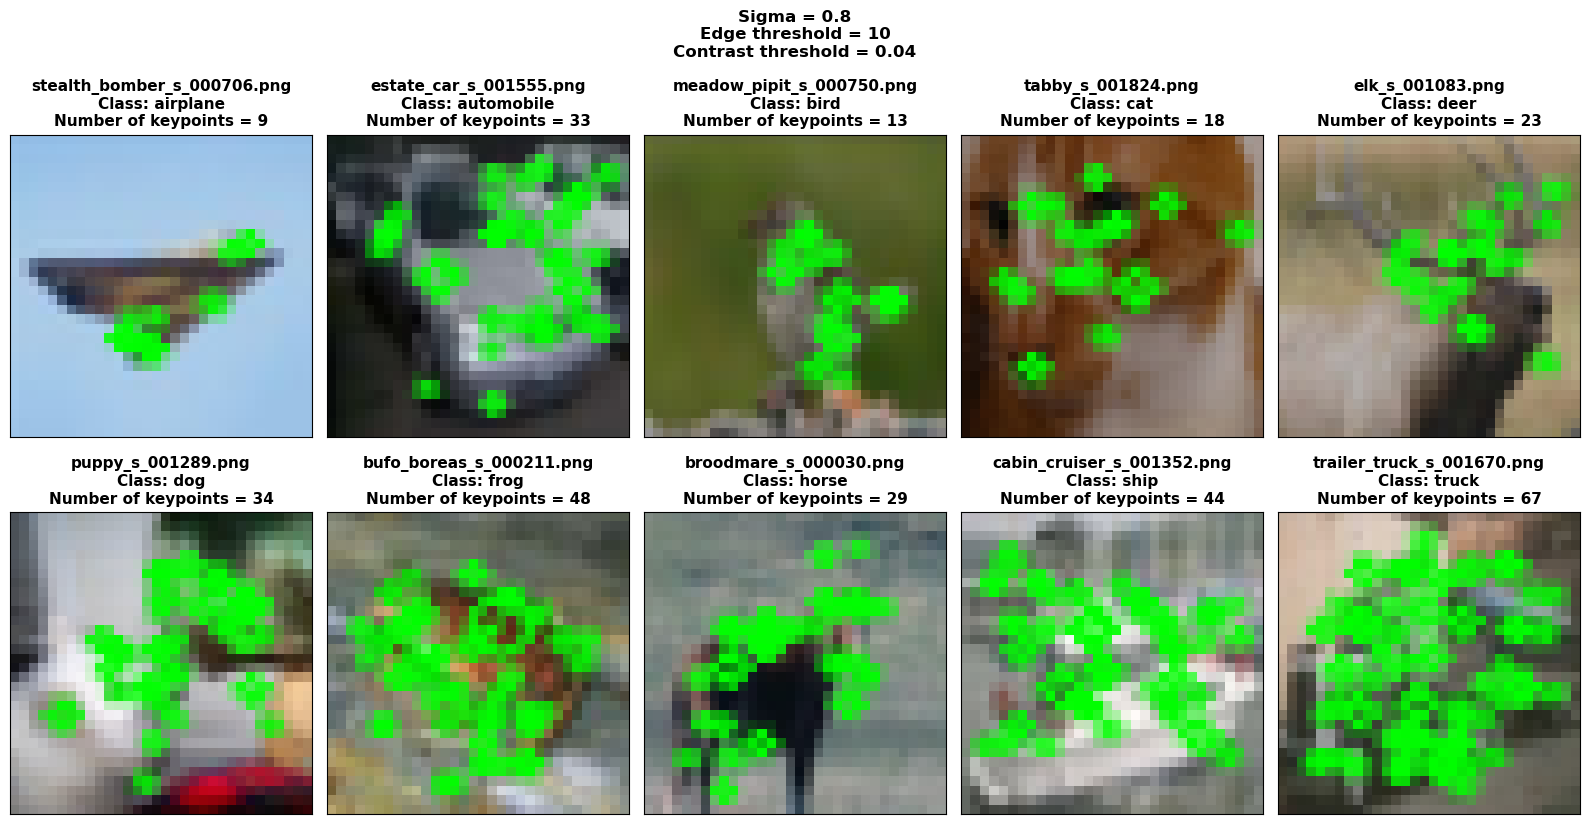

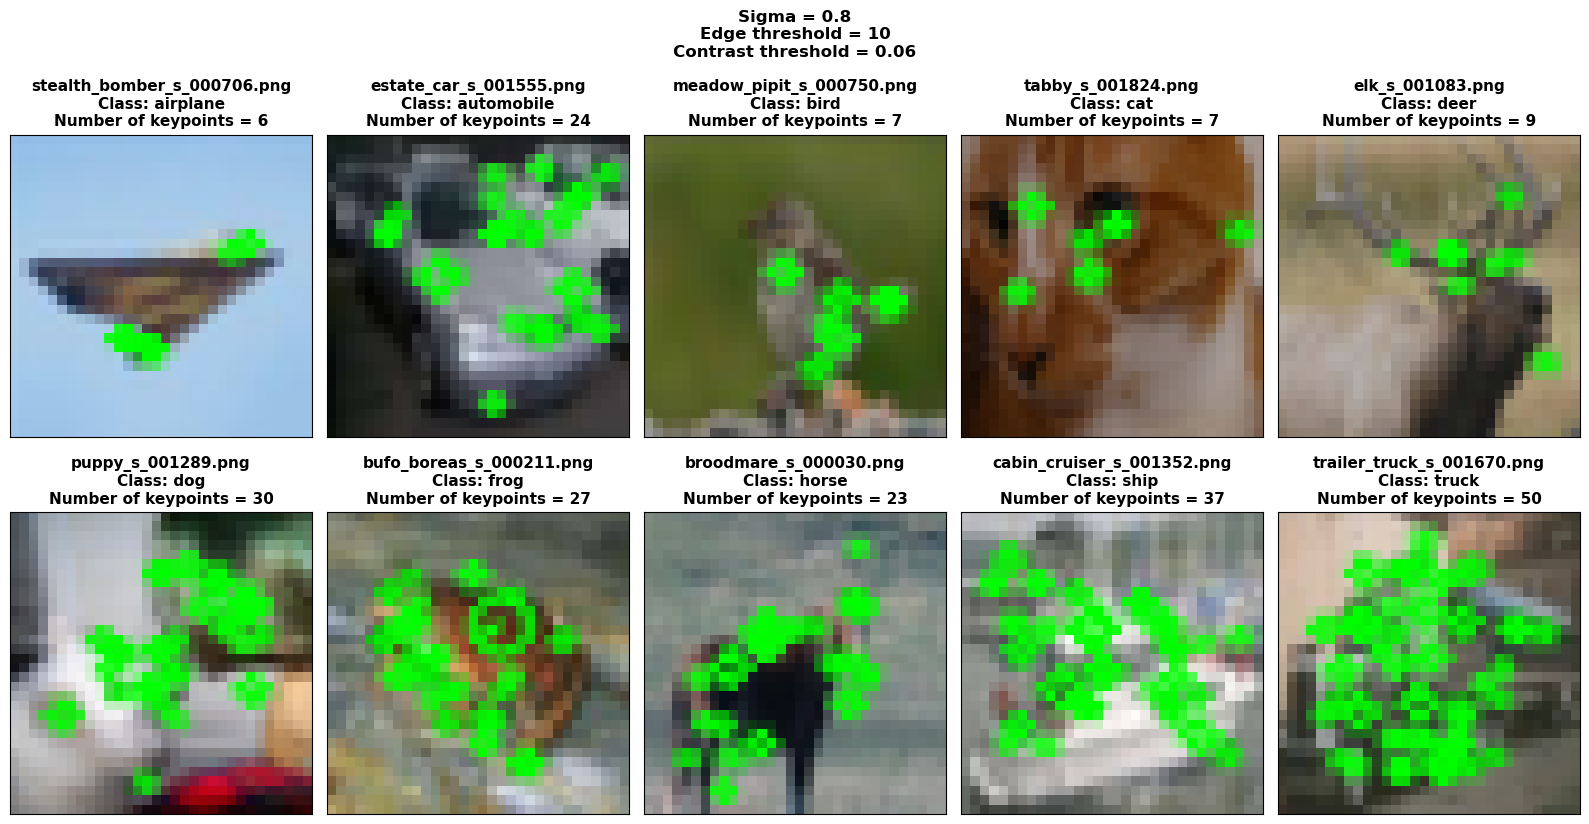

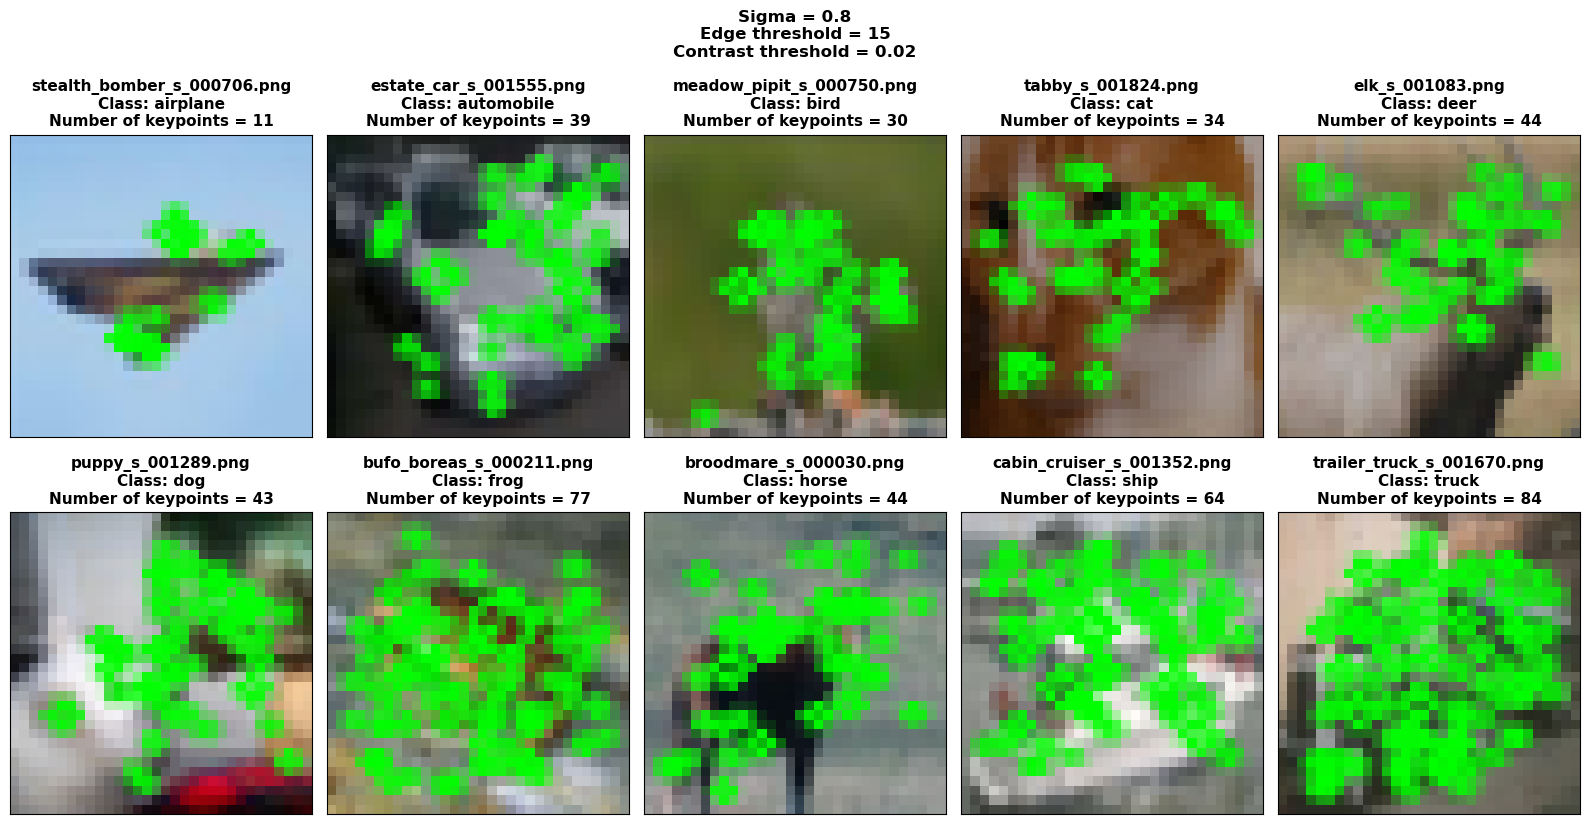

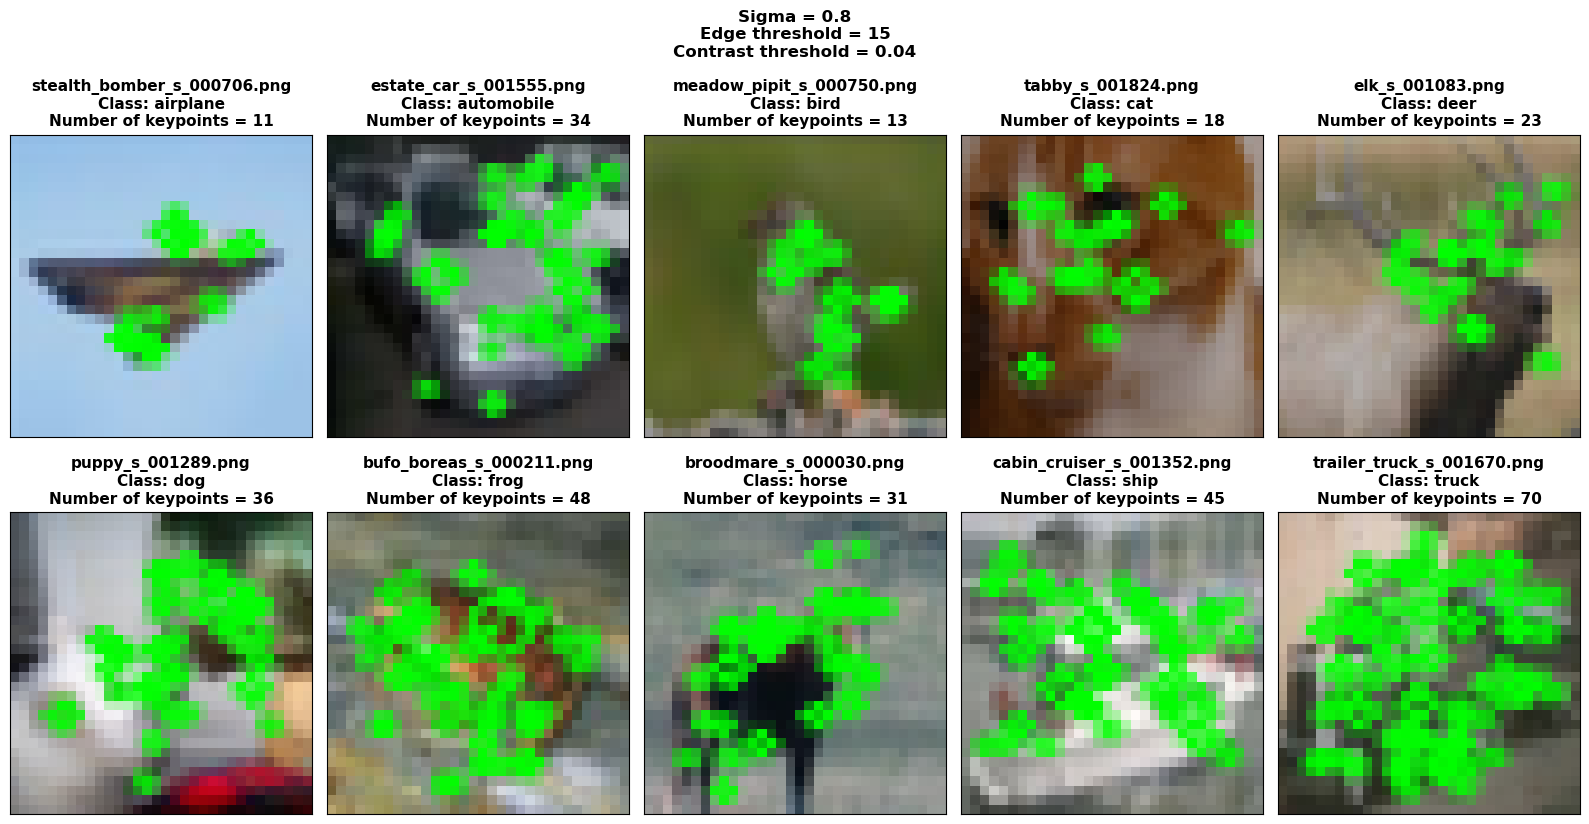

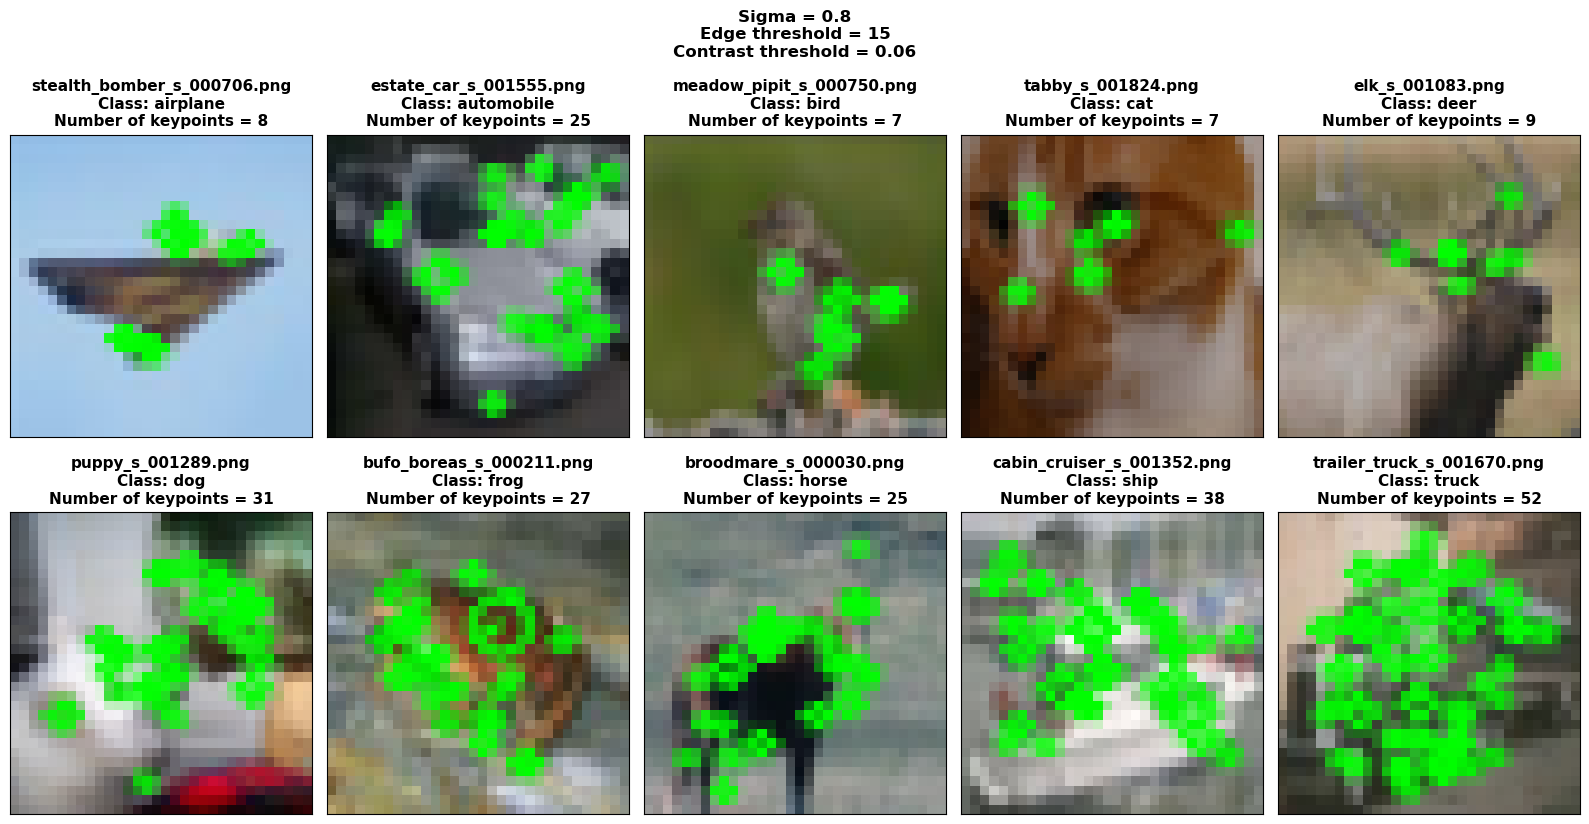

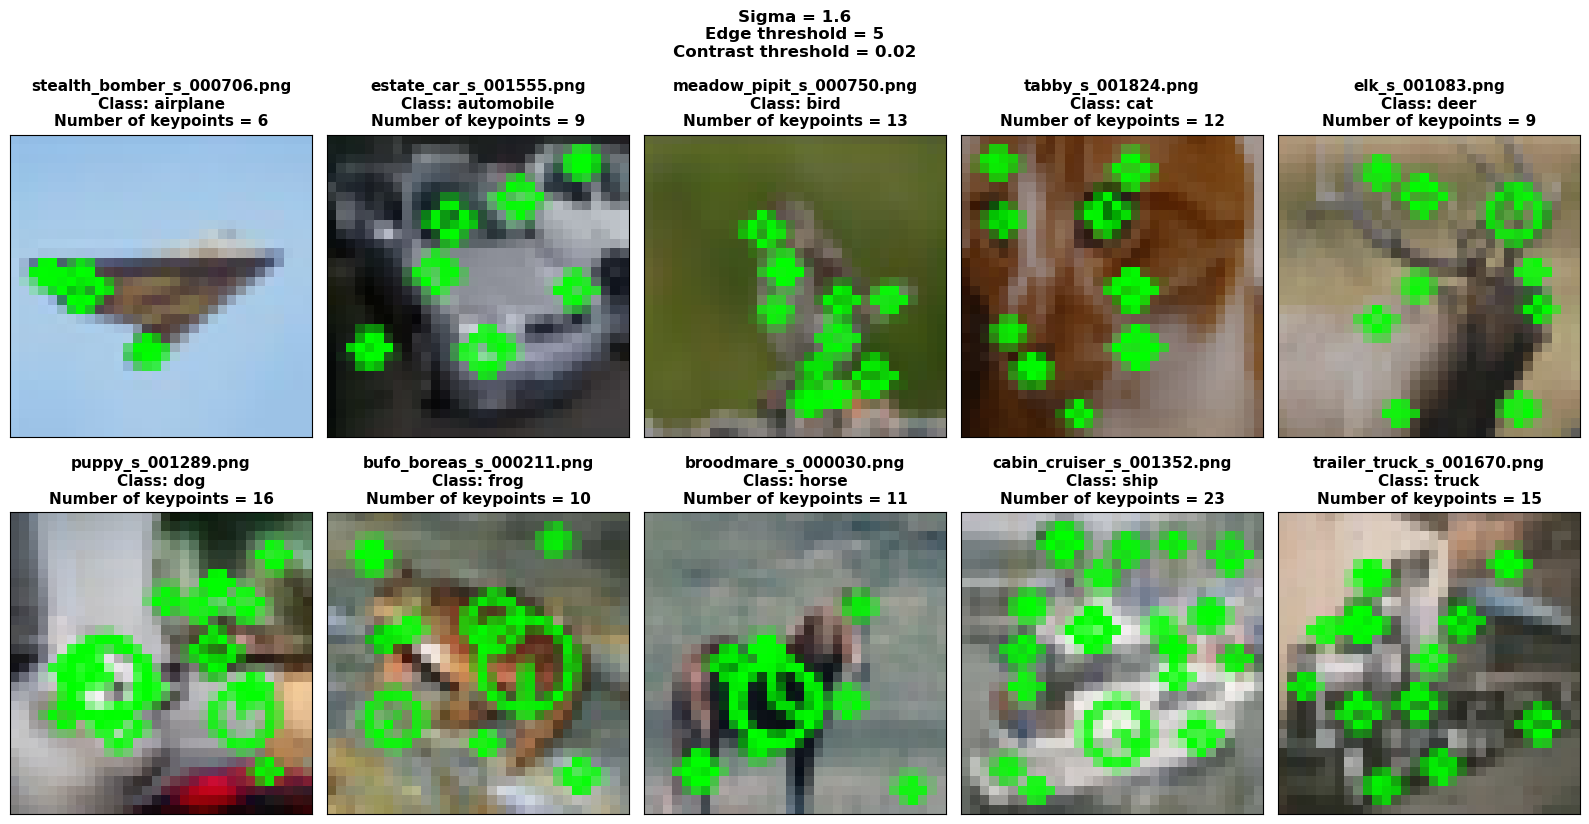

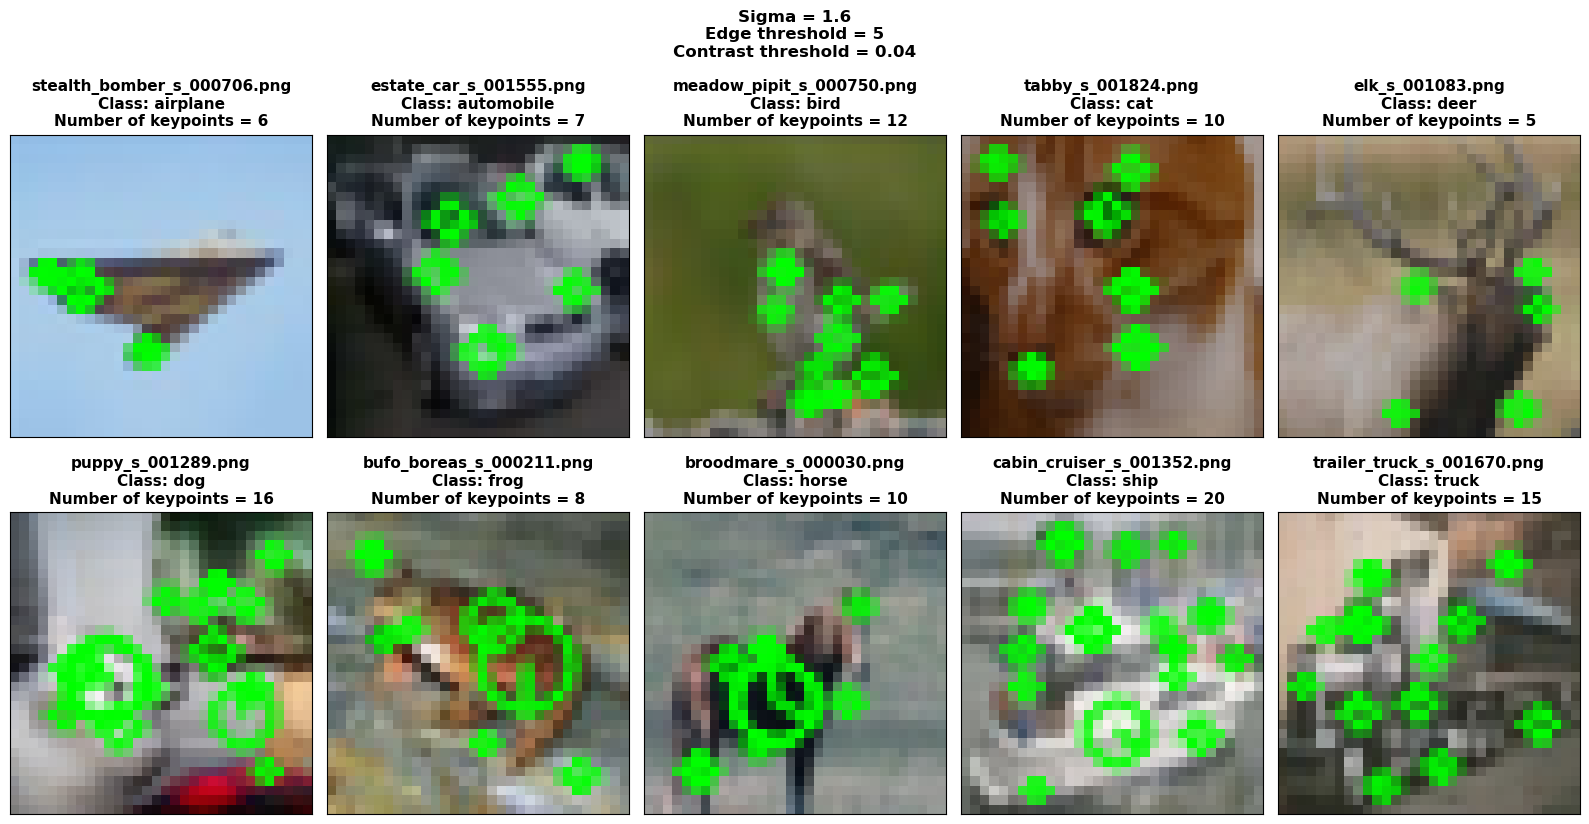

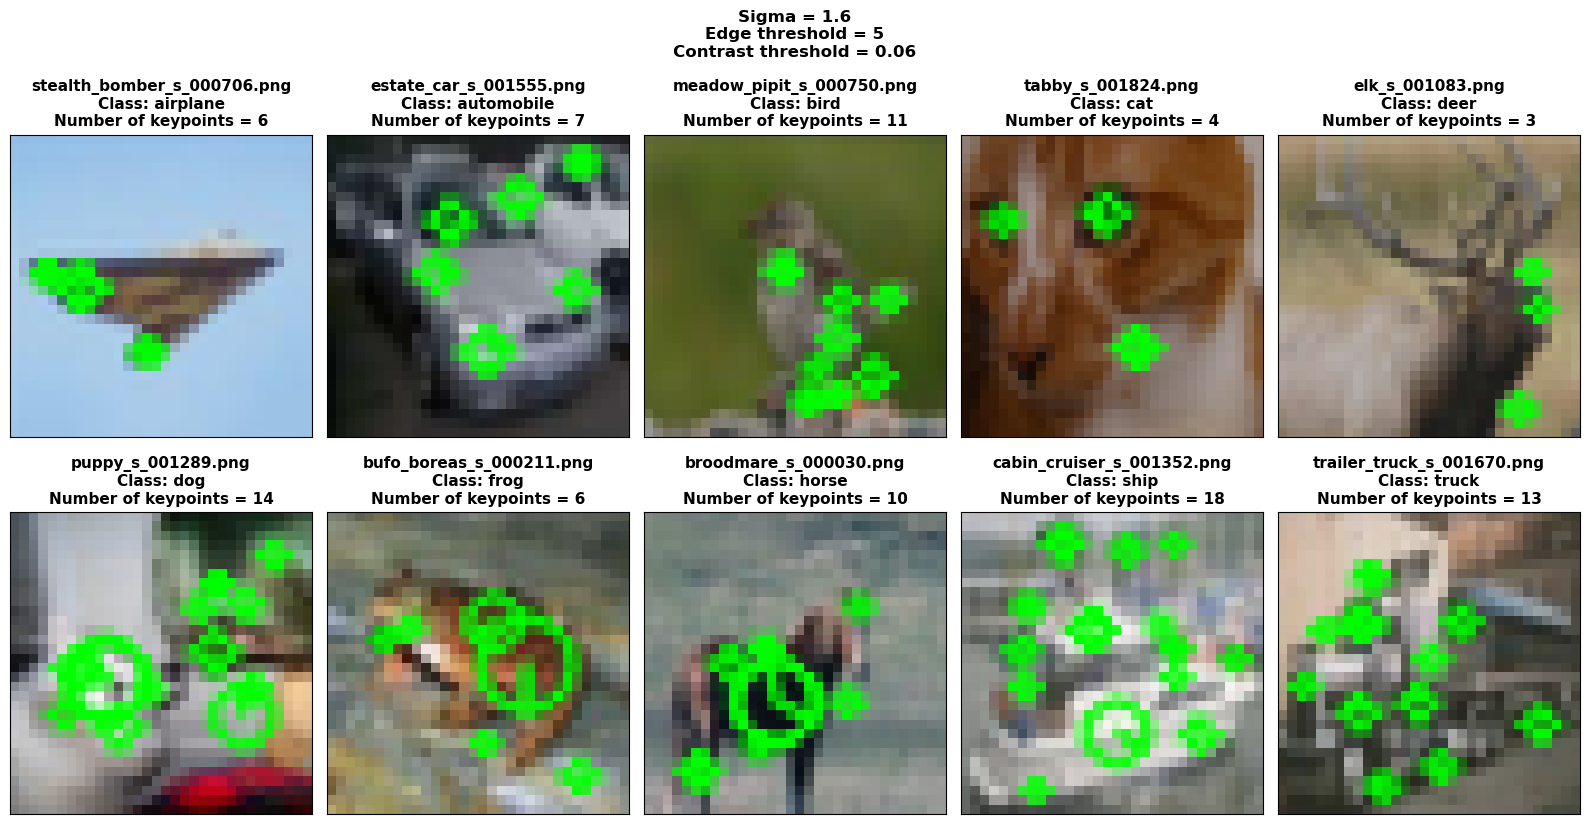

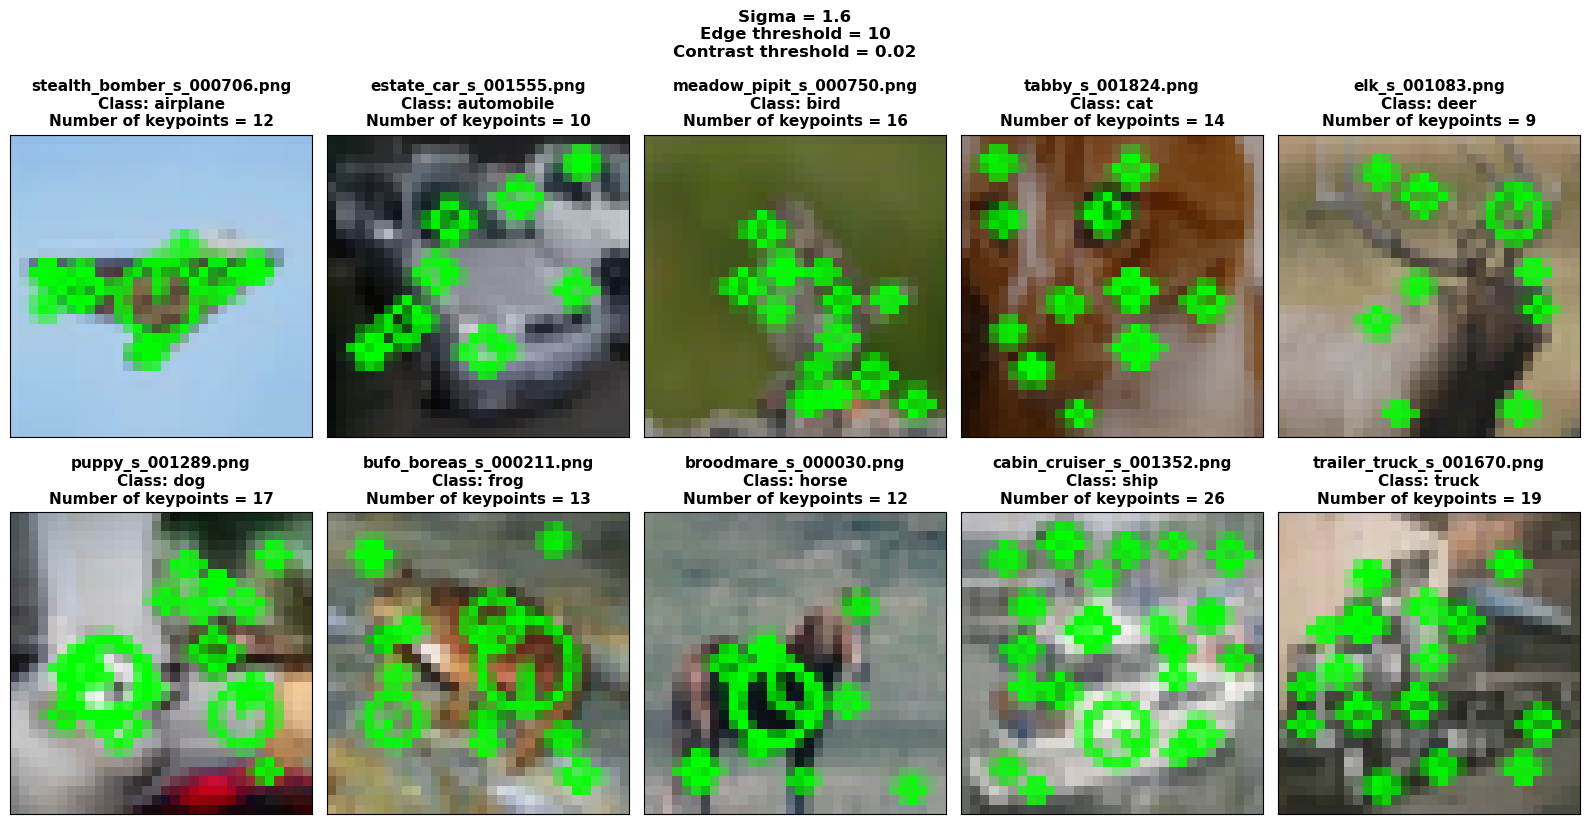

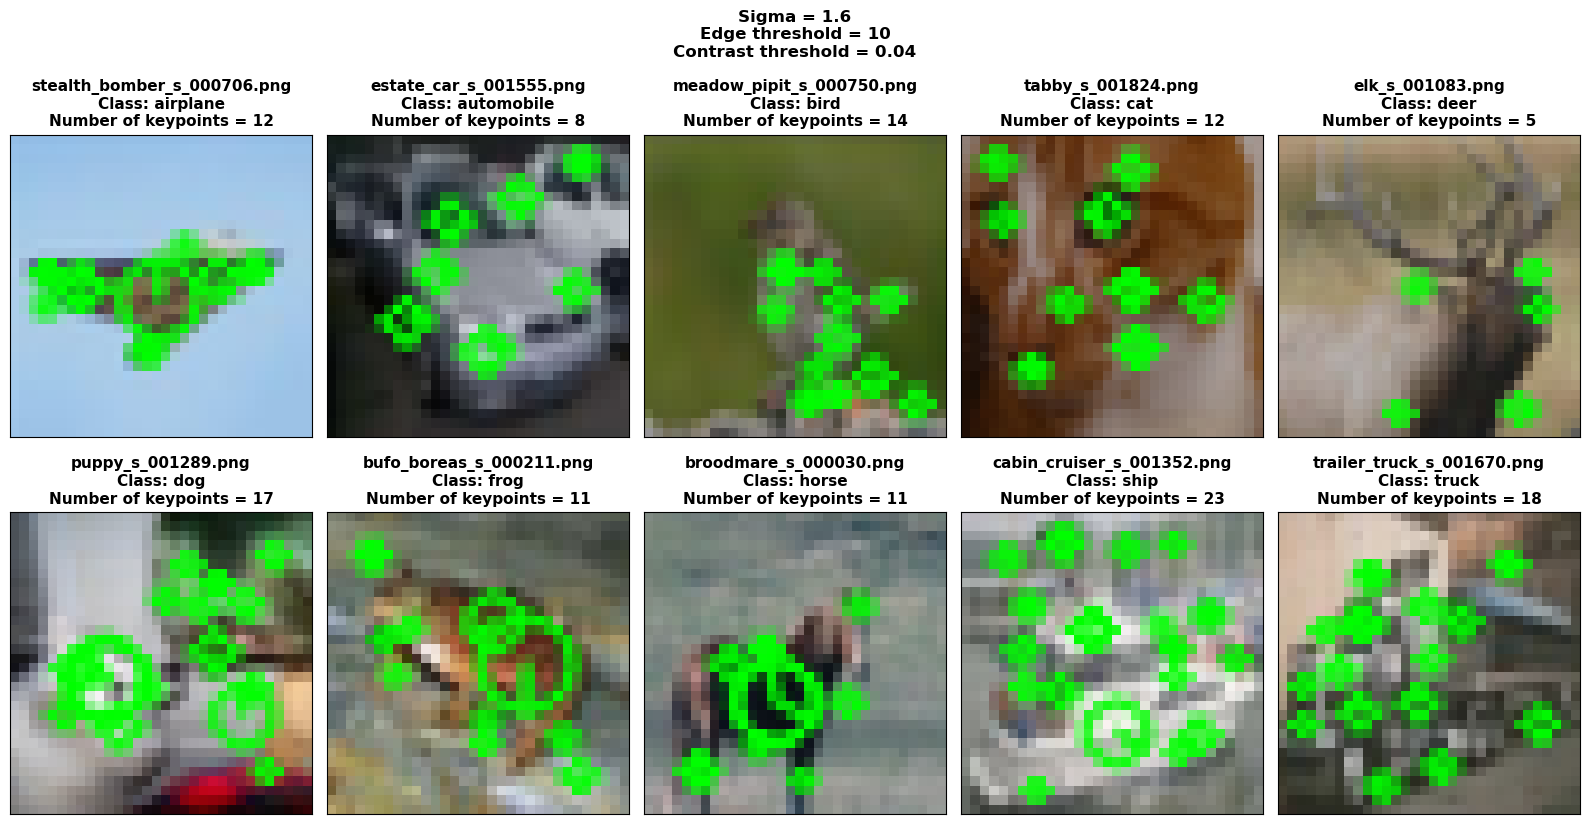

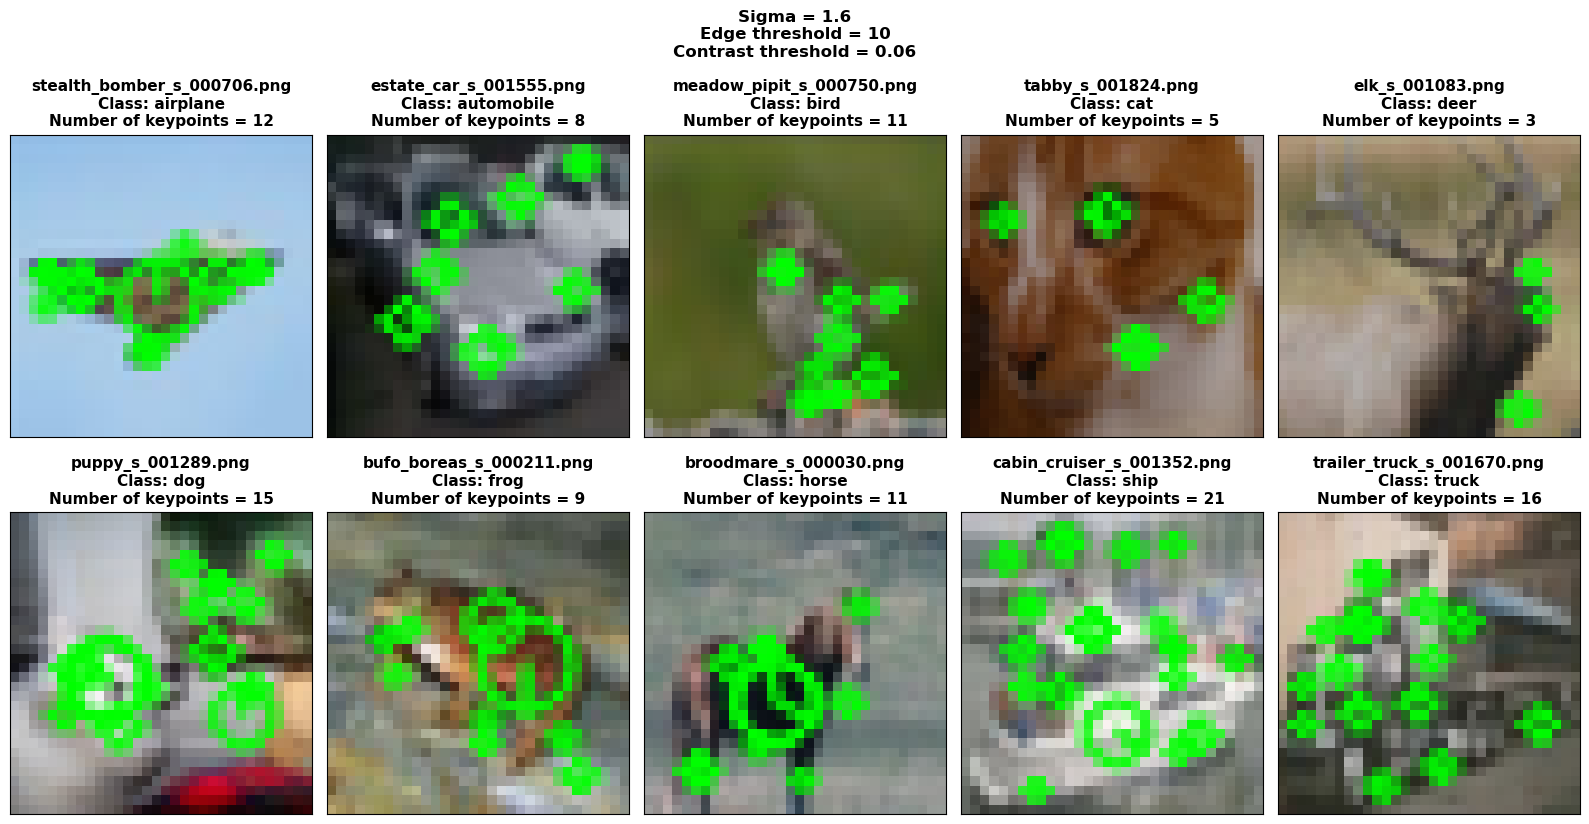

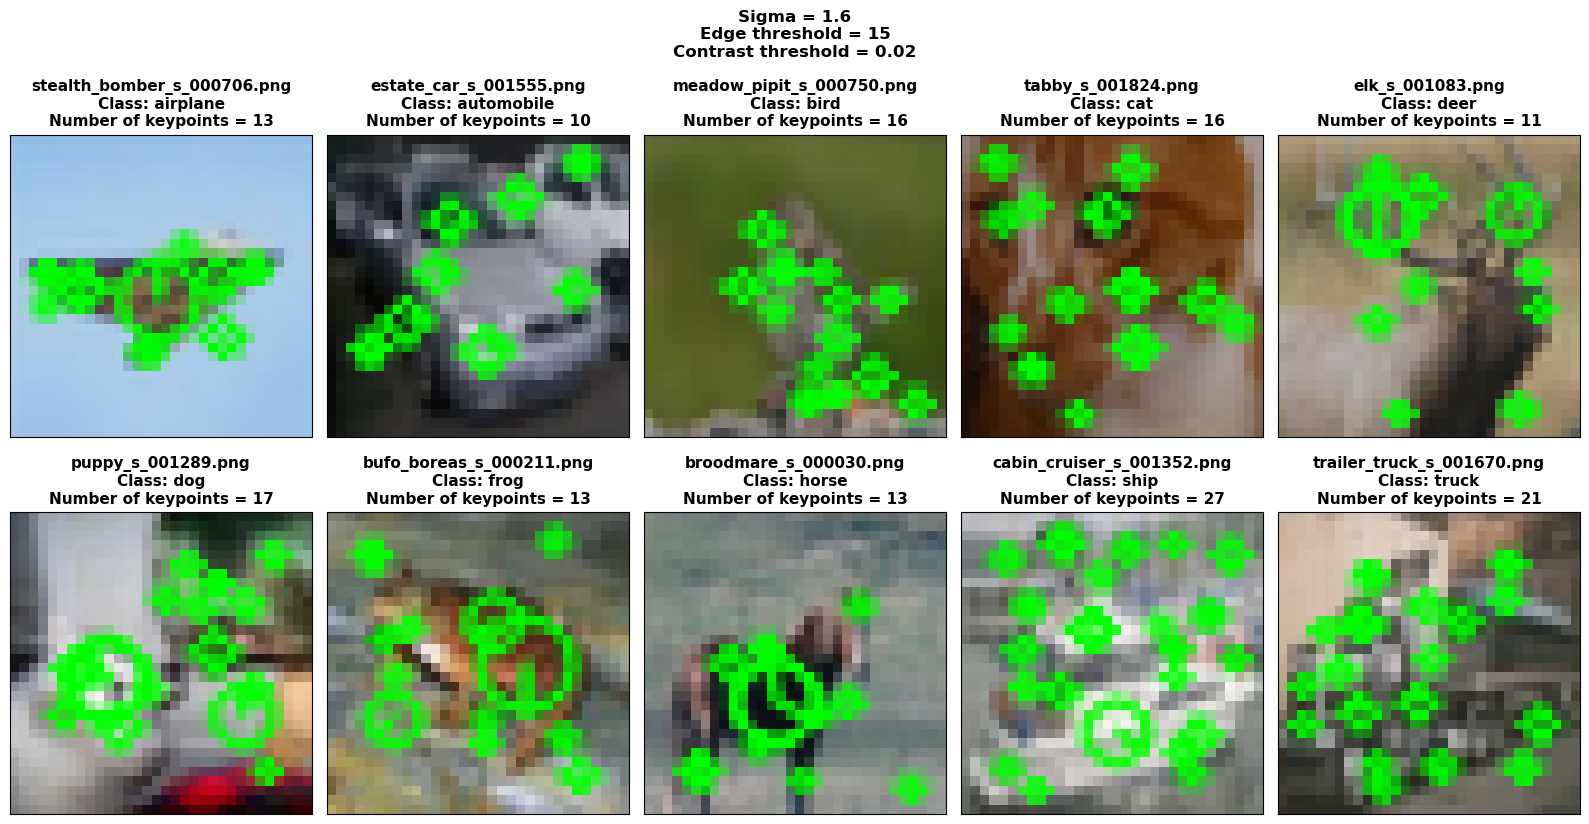

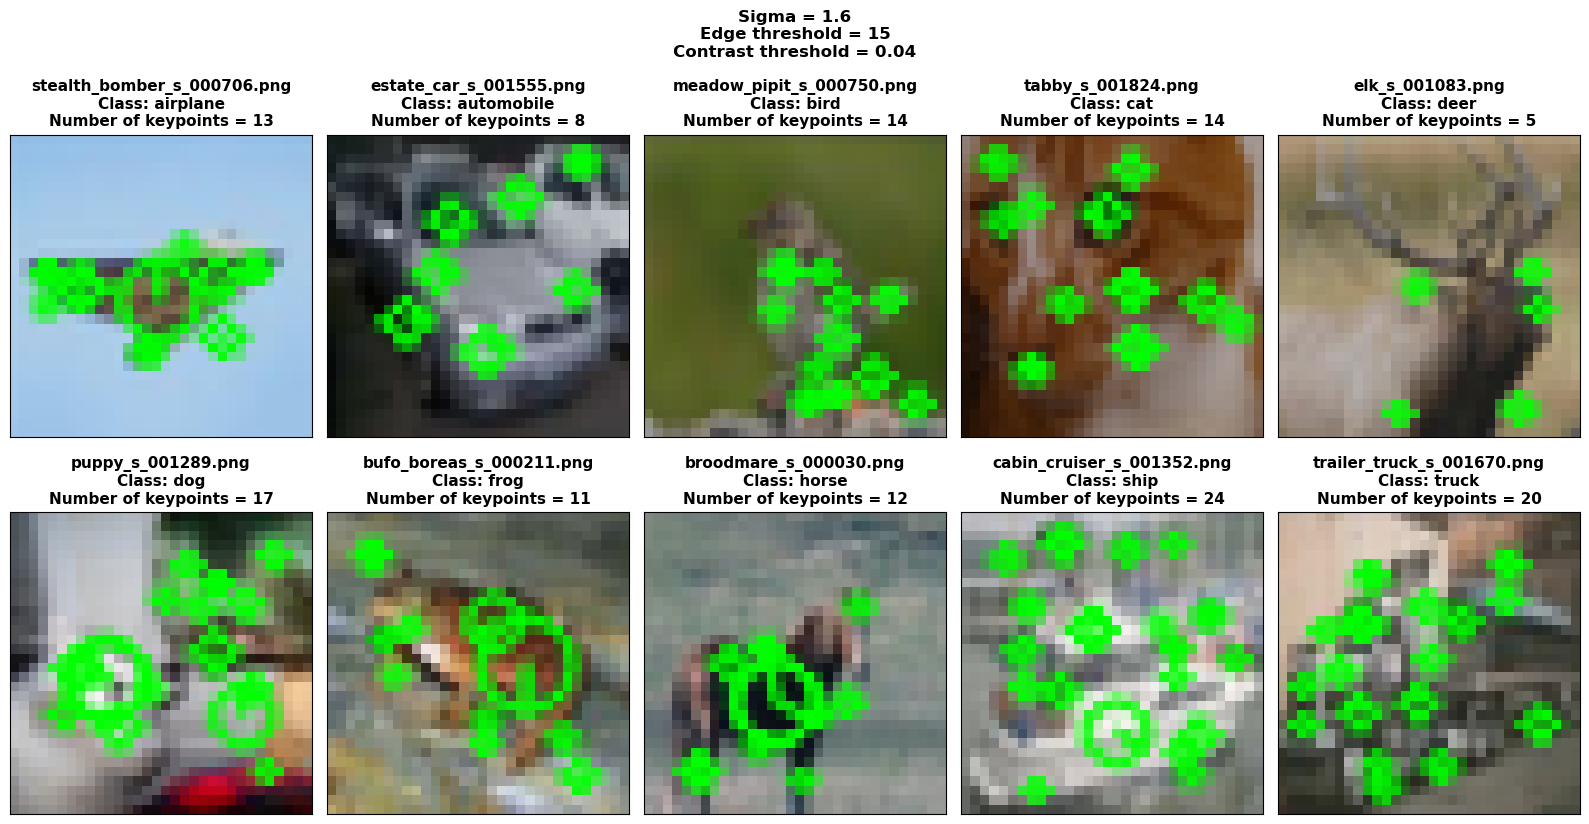

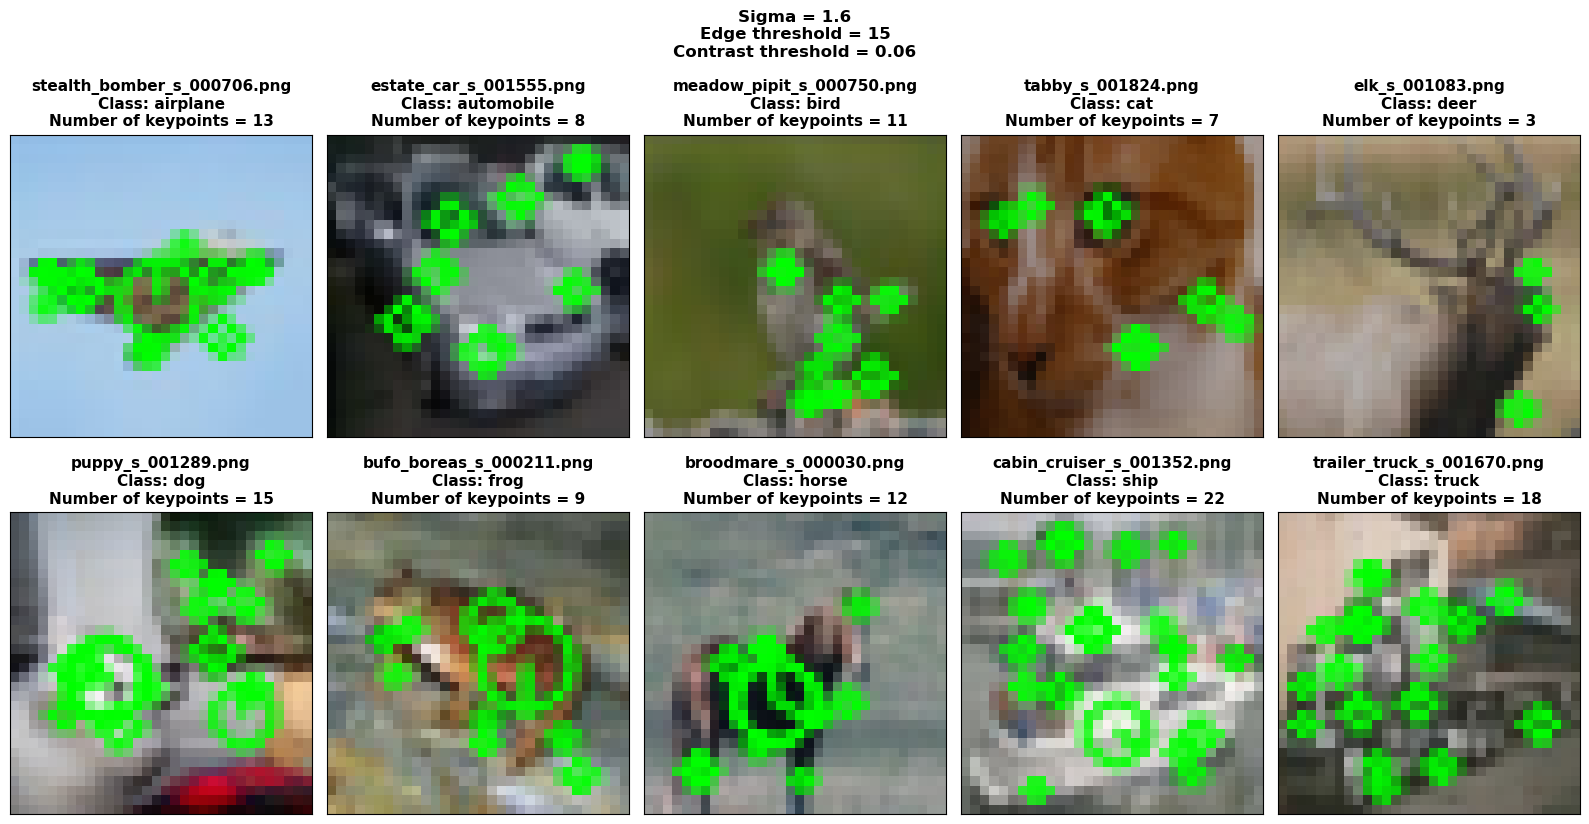

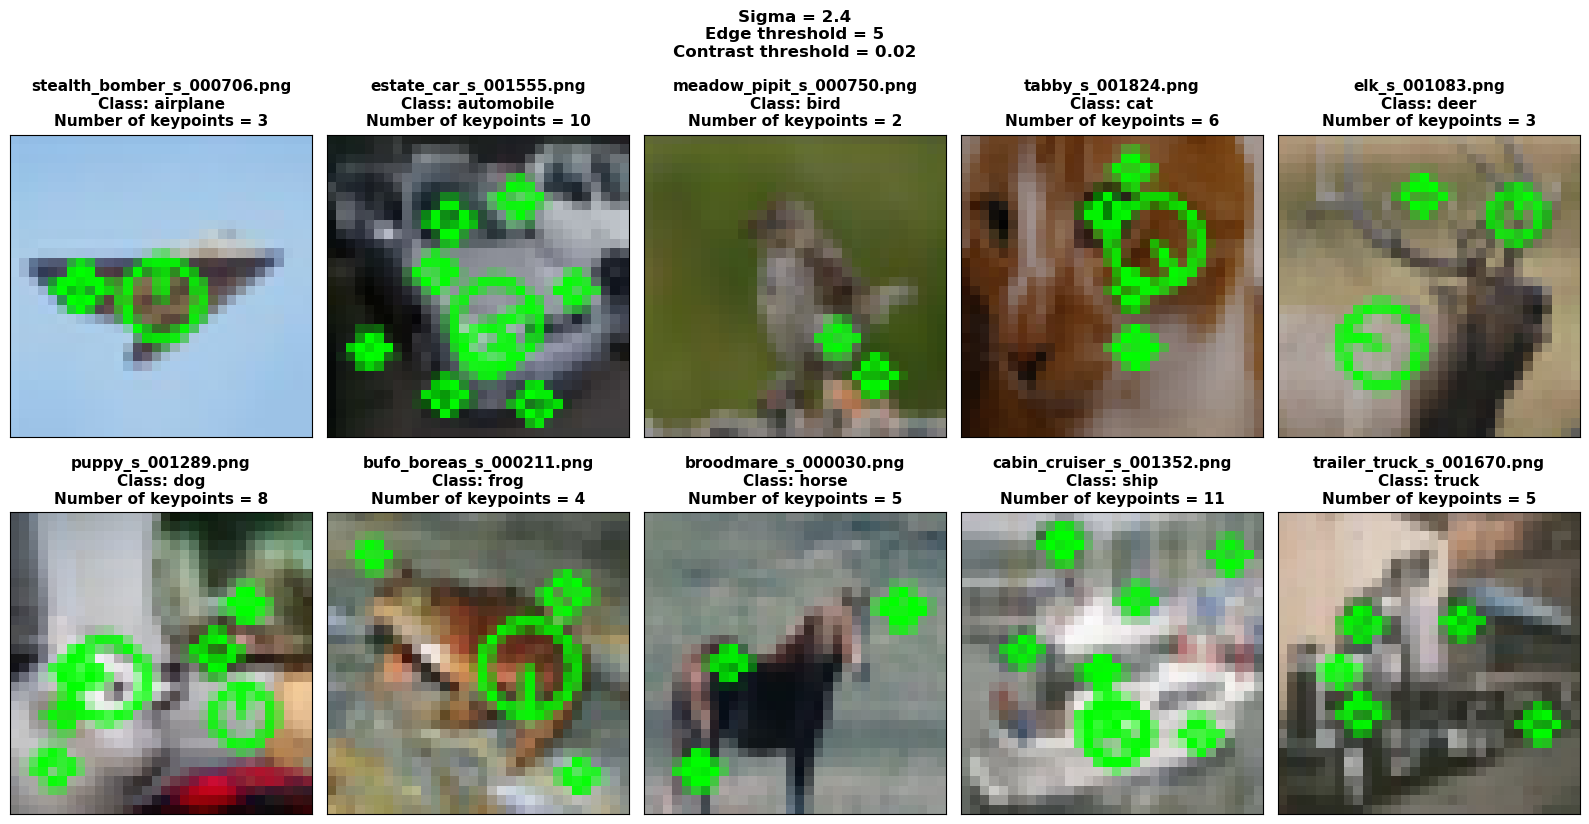

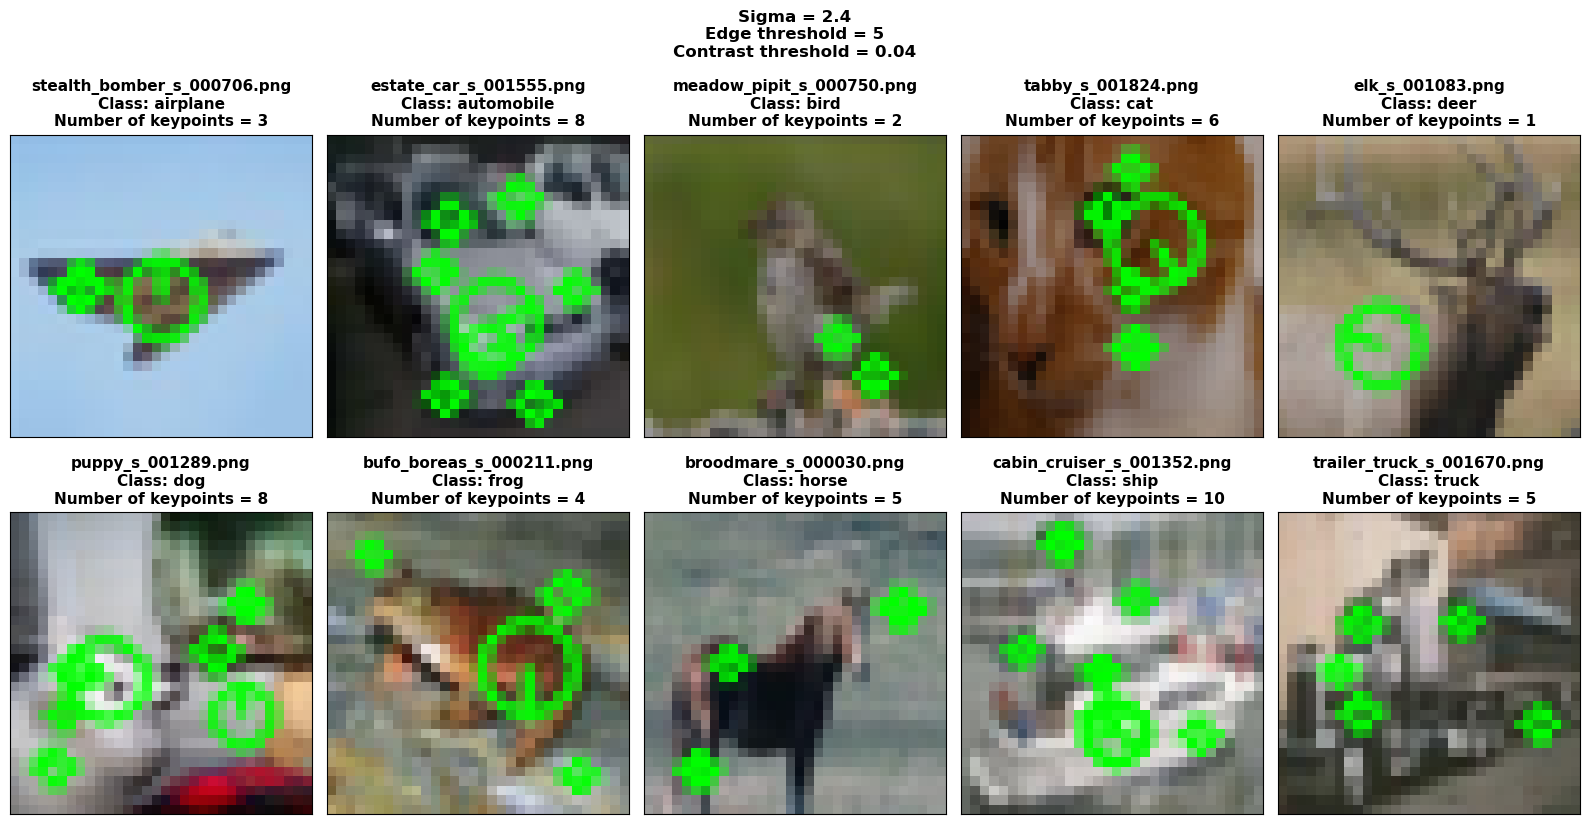

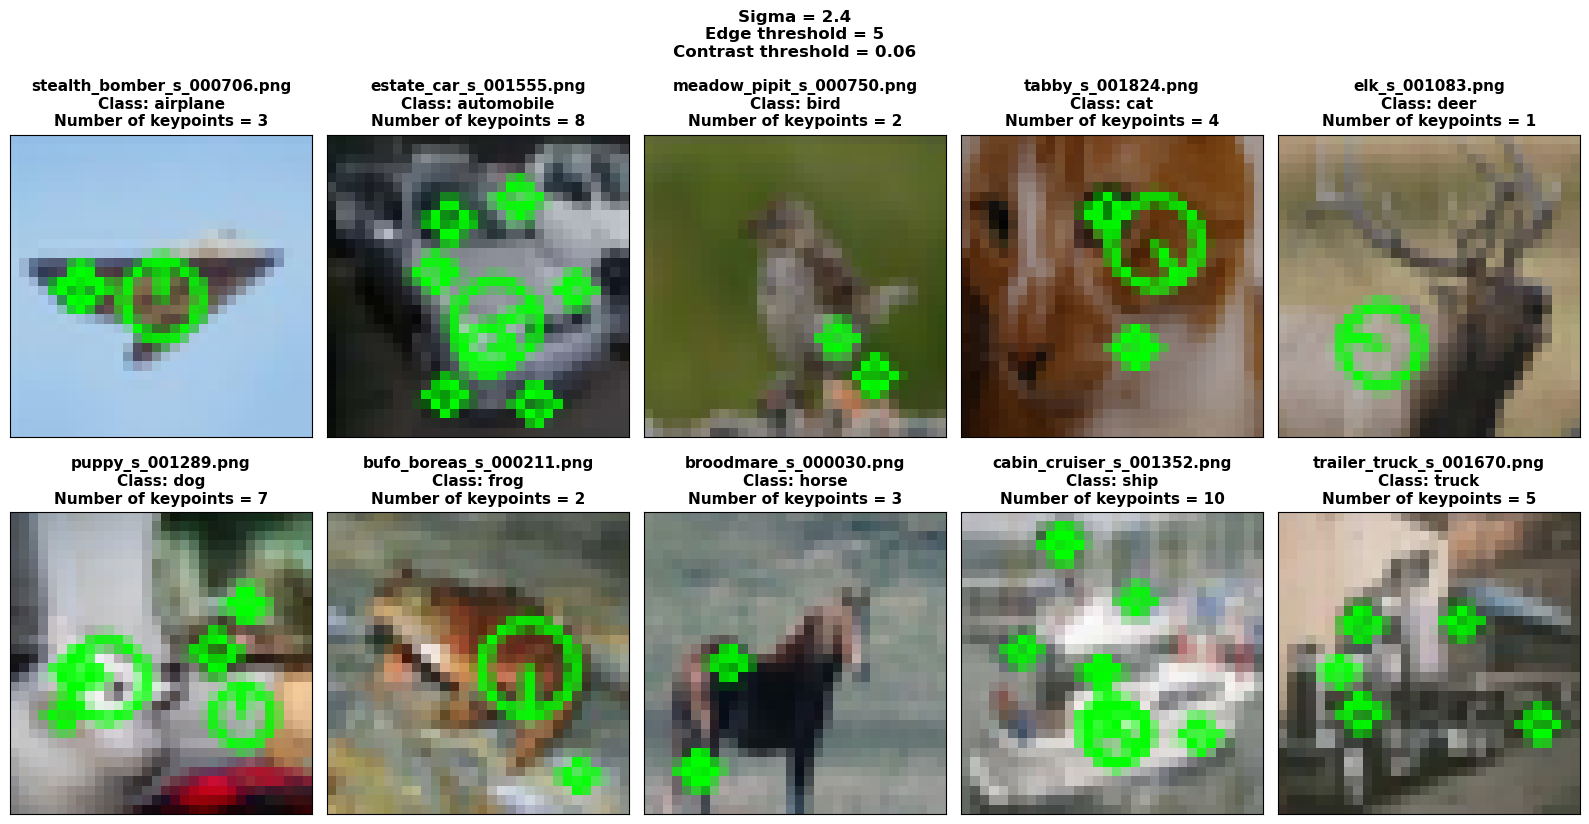

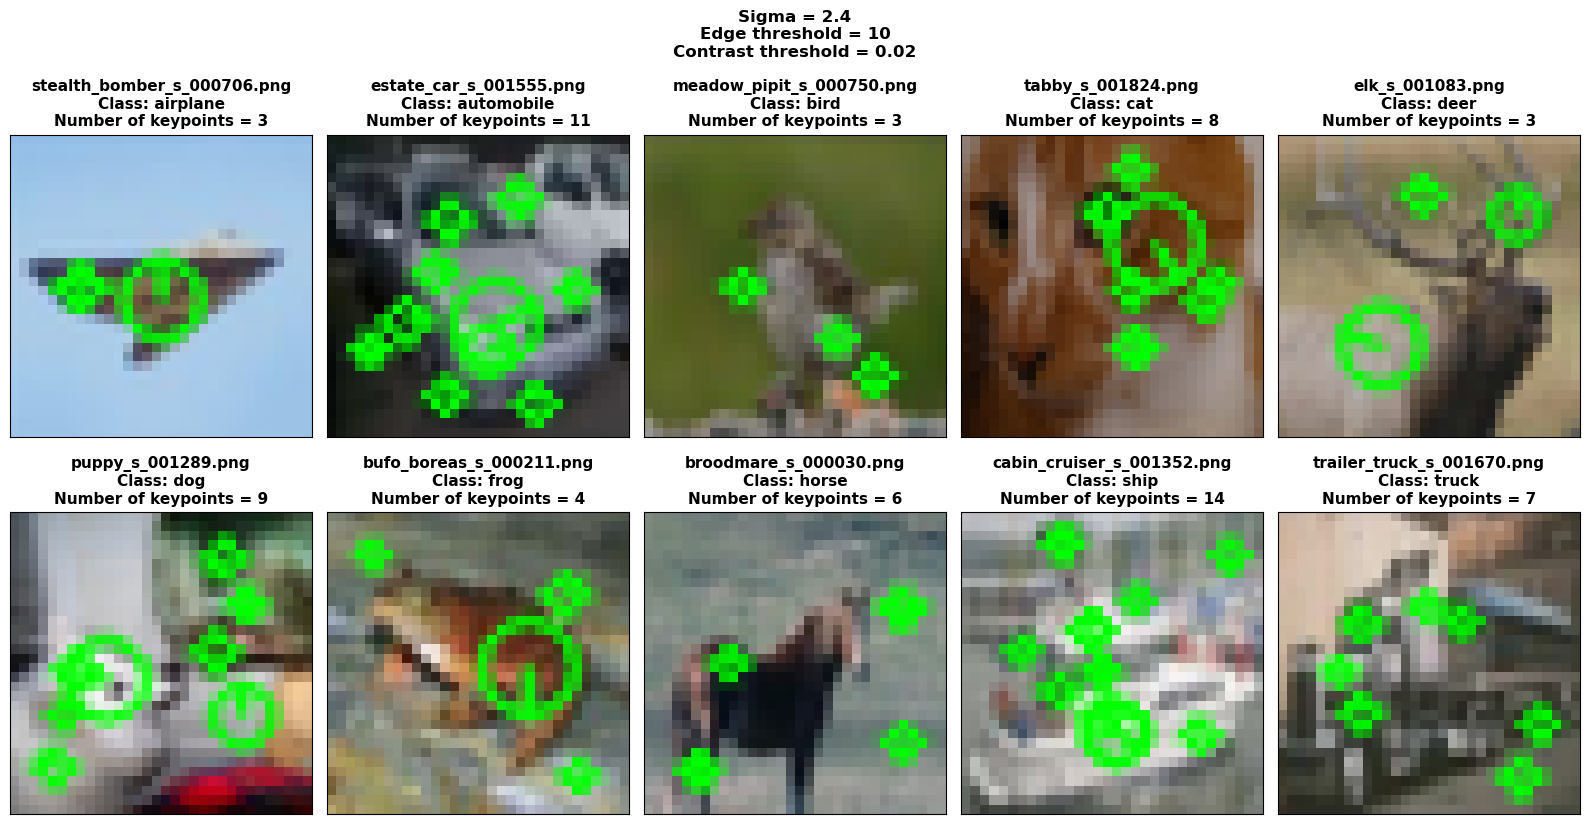

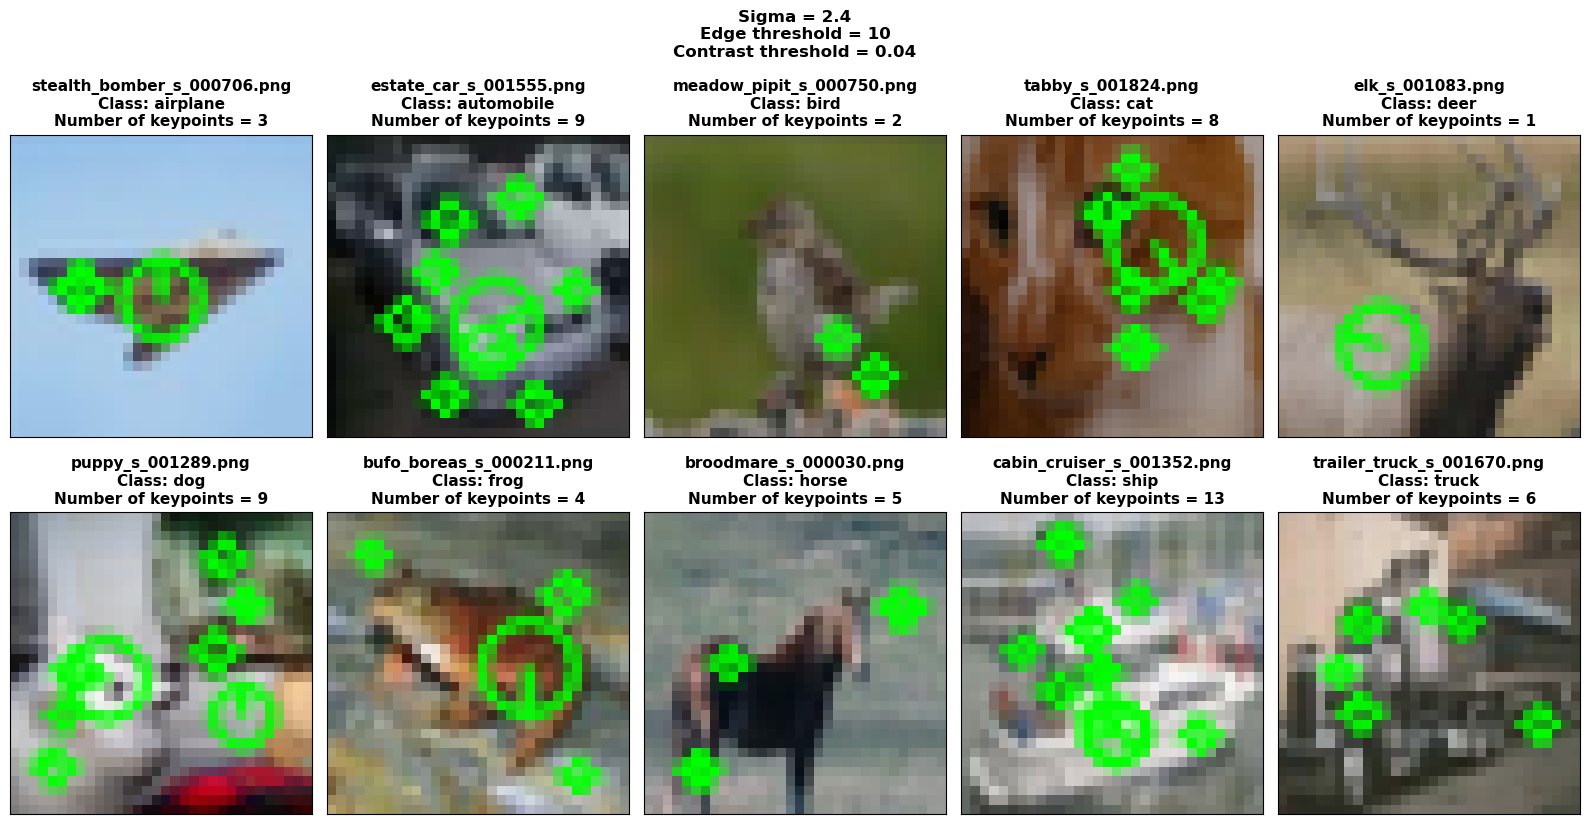

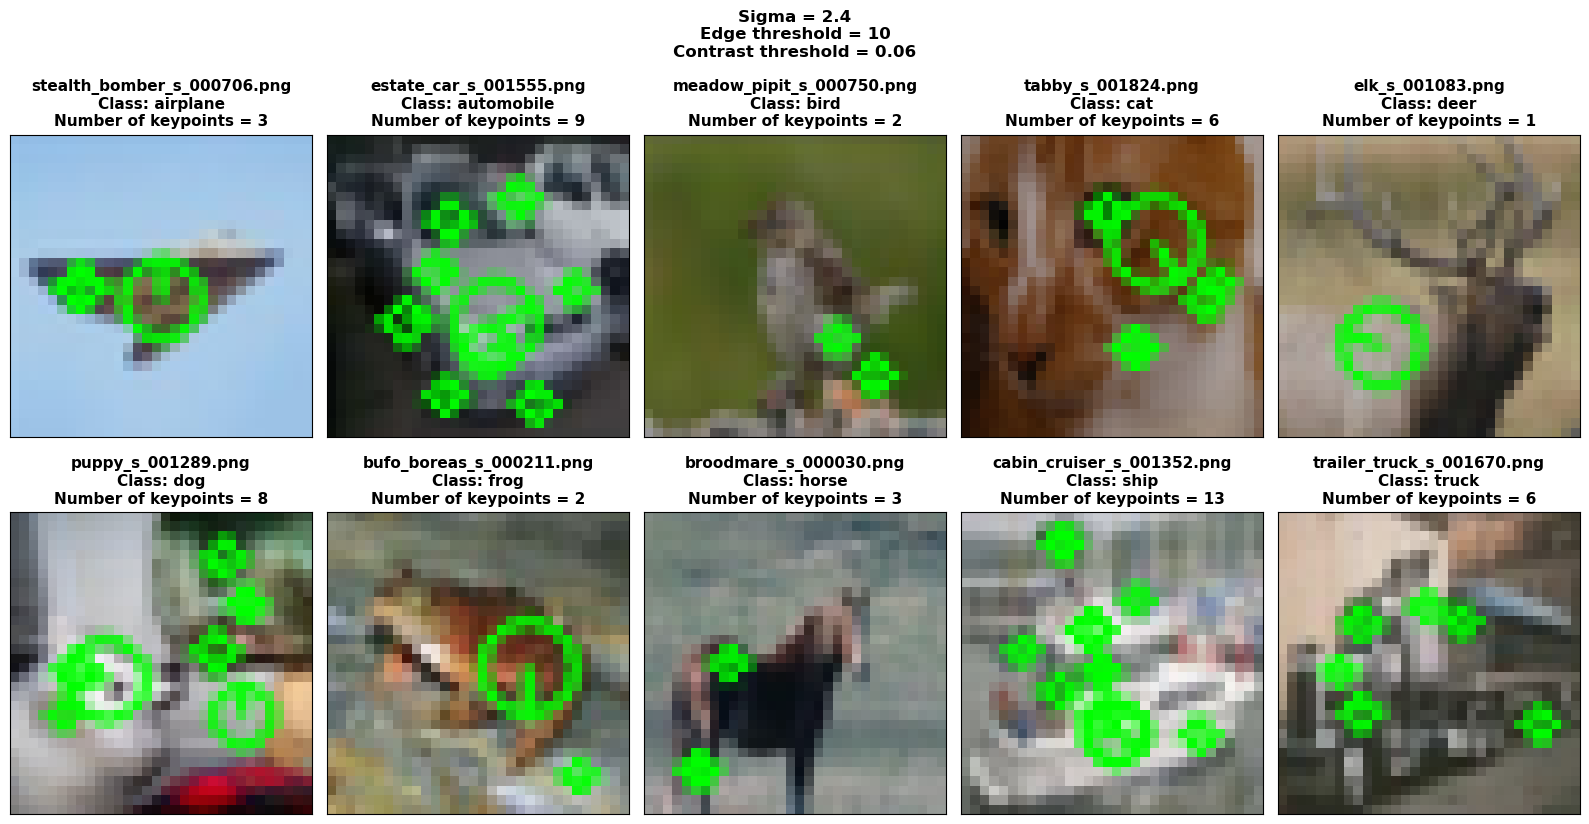

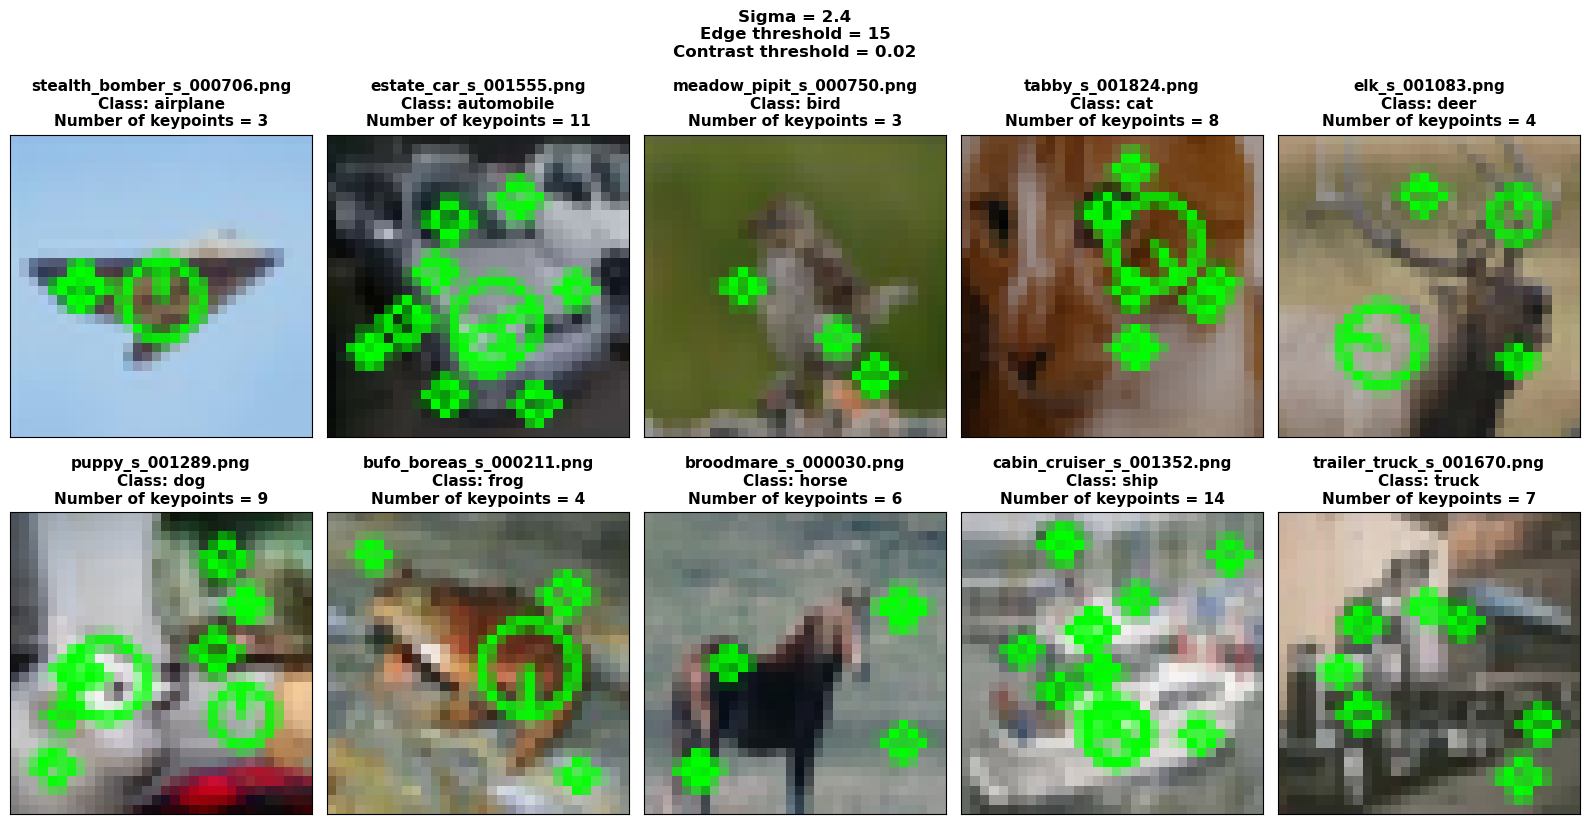

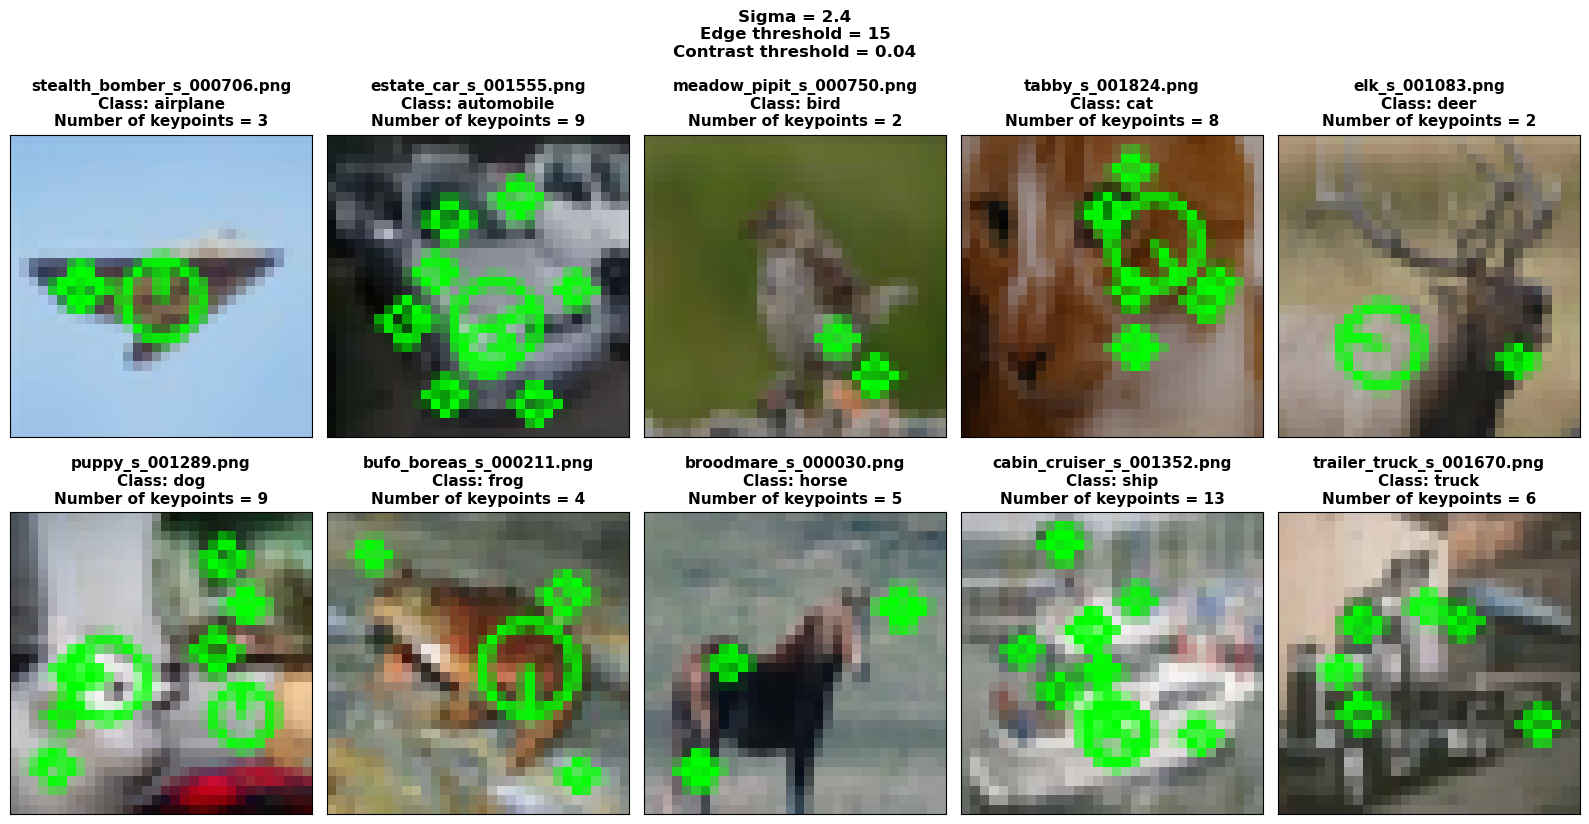

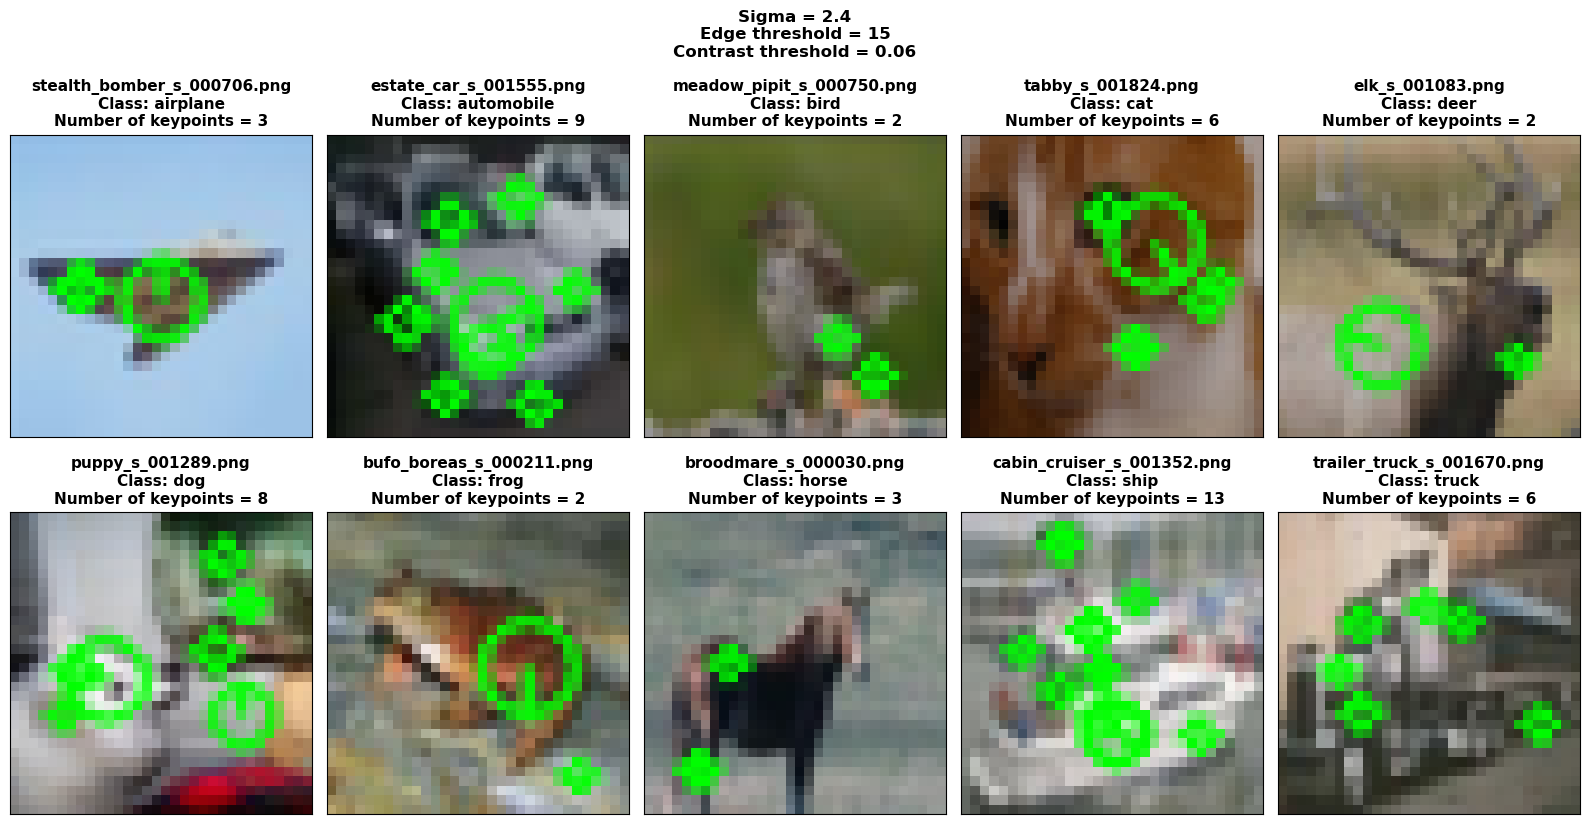

In [10]:
@dataclass
class SIFTStats:
    sigma: float
    edgeThreshold: float
    contrastThreshold: float
    num_keypoints: int

statistics: dict[str, list[SIFTStats]] = {img.filename: [] for img in img_data}

# make its own directory for SIFT images, since there'll be a lot
os.mkdir(FIGURE_PATH + "/sift")

for sigma in [0.8, 1.6, 2.4]:
    for edgeThreshold in [5, 10, 15]:
        for contrastThreshold in [0.02, 0.04, 0.06]:
            # Create SIFT object.
            # Docs: https://docs.opencv.org/4.9.0/d7/d60/classcv_1_1SIFT.html
            SIFT = cv.SIFT.create(sigma = sigma, edgeThreshold = edgeThreshold, contrastThreshold = contrastThreshold)

            # Create figures
            fig, ax = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
            fig.suptitle(f"Sigma = {sigma}\nEdge threshold = {edgeThreshold}\nContrast threshold = {contrastThreshold}", fontweight = 'bold')
            ax = ax.flatten() # flatten array to iterate with a single loop

            for img, a in zip(img_data, ax):   
                # Get keypoints of image with SIFT object
                keypoints = SIFT.detect(img.rgb)
                
                # Copy source image for output image
                output_img = np.copy(img.rgb)
                
                # Draw keypoints
                cv.drawKeypoints(img.rgb, keypoints, output_img, color = GREEN_U8, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                
                statistics[img.filename].append(
                    SIFTStats(
                        sigma = sigma, 
                        edgeThreshold = edgeThreshold, 
                        contrastThreshold = contrastThreshold,
                        num_keypoints = len(keypoints)
                    )
                )
                
                # Plot images
                a.imshow(output_img)
                a.set_title(f"{img.filename}\nClass: {img.img_class}\nNumber of keypoints = {len(keypoints)}", fontsize = 11, fontweight = 'bold')
                
                # remove x/y-ticks from image
                a.set_xticks([])
                a.set_yticks([])
                a.set_xticklabels([])
                a.set_yticklabels([])
                
            fig.savefig(figure_path(f"sift/sigma_{sigma}_edge_{edgeThreshold}_contrast_{contrastThreshold}.png"))

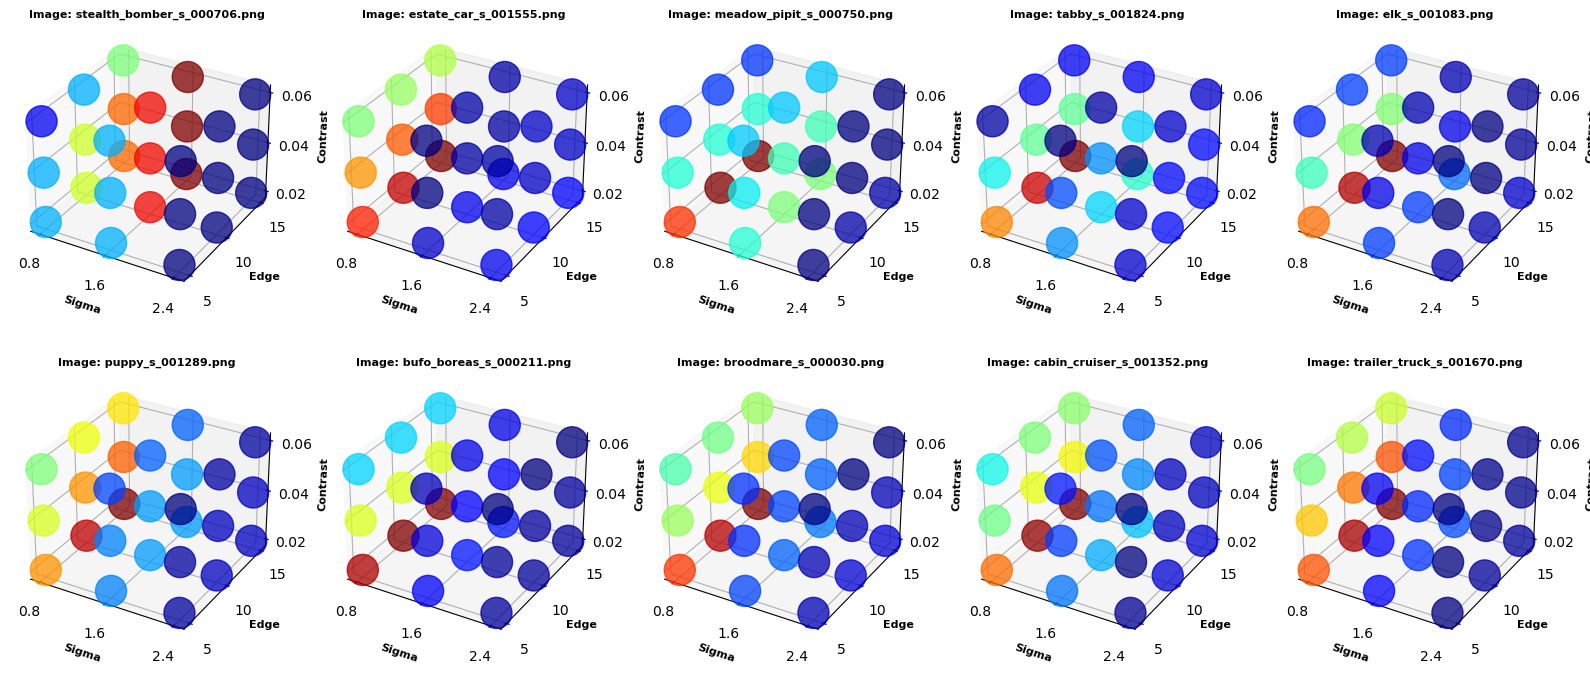

In [11]:
fig, ax = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True, subplot_kw=dict(projection='3d'))
plt.subplots_adjust(wspace=0.25,hspace=0.25)

ax = ax.flatten() # flatten array to iterate with a single loop

for ii,k in enumerate(statistics):
    sigma = np.array([_v.sigma for _v in statistics[k]])
    edgeThreshold = np.array([_v.edgeThreshold for _v in statistics[k]])
    contrastThreshold = np.array([_v.contrastThreshold for _v in statistics[k]])
    num_keypoints = np.array([_v.num_keypoints for _v in statistics[k]])
    
    plt.jet()
    
    sc = ax[ii].scatter(sigma, edgeThreshold, contrastThreshold, c = num_keypoints, s = 500, alpha = 0.75)
    
    ax[ii].set_xticks(np.unique(sigma))
    ax[ii].set_yticks(np.unique(edgeThreshold))
    ax[ii].set_zticks(np.unique(contrastThreshold))
    ax[ii].set_ylabel("Edge", fontweight = 'bold', fontsize = 8)
    ax[ii].set_xlabel("Sigma", fontweight = 'bold', fontsize = 8)
    ax[ii].set_zlabel("Contrast", fontweight = 'bold', fontsize = 8)
    ax[ii].set_title(f"Image: {k}", fontweight = 'bold', fontsize = 8)
    
fig.savefig(figure_path("sift_stat_distribution.png"))